In [100]:
import pandas as pd
import glob
import os
import numpy as np
import pickle
import statistics
import community
import matplotlib as mlp
# matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt

import networkx as nx

import analysis as an
import pandas as pd
import statsmodels as st
import statsmodels.api as sm
from statsmodels.formula.api import ols

from visbrain.objects import BrainObj, ColorbarObj, SceneObj, SourceObj
from visbrain.io import download_file, read_stc

from nilearn.connectome import ConnectivityMeasure

from nilearn import plotting
#plt.matshow(rwd_mean_correlation_matrix,cmap='hot')

import numpy as np
import seaborn as sns

from scipy import stats as spy_stats

(100,)


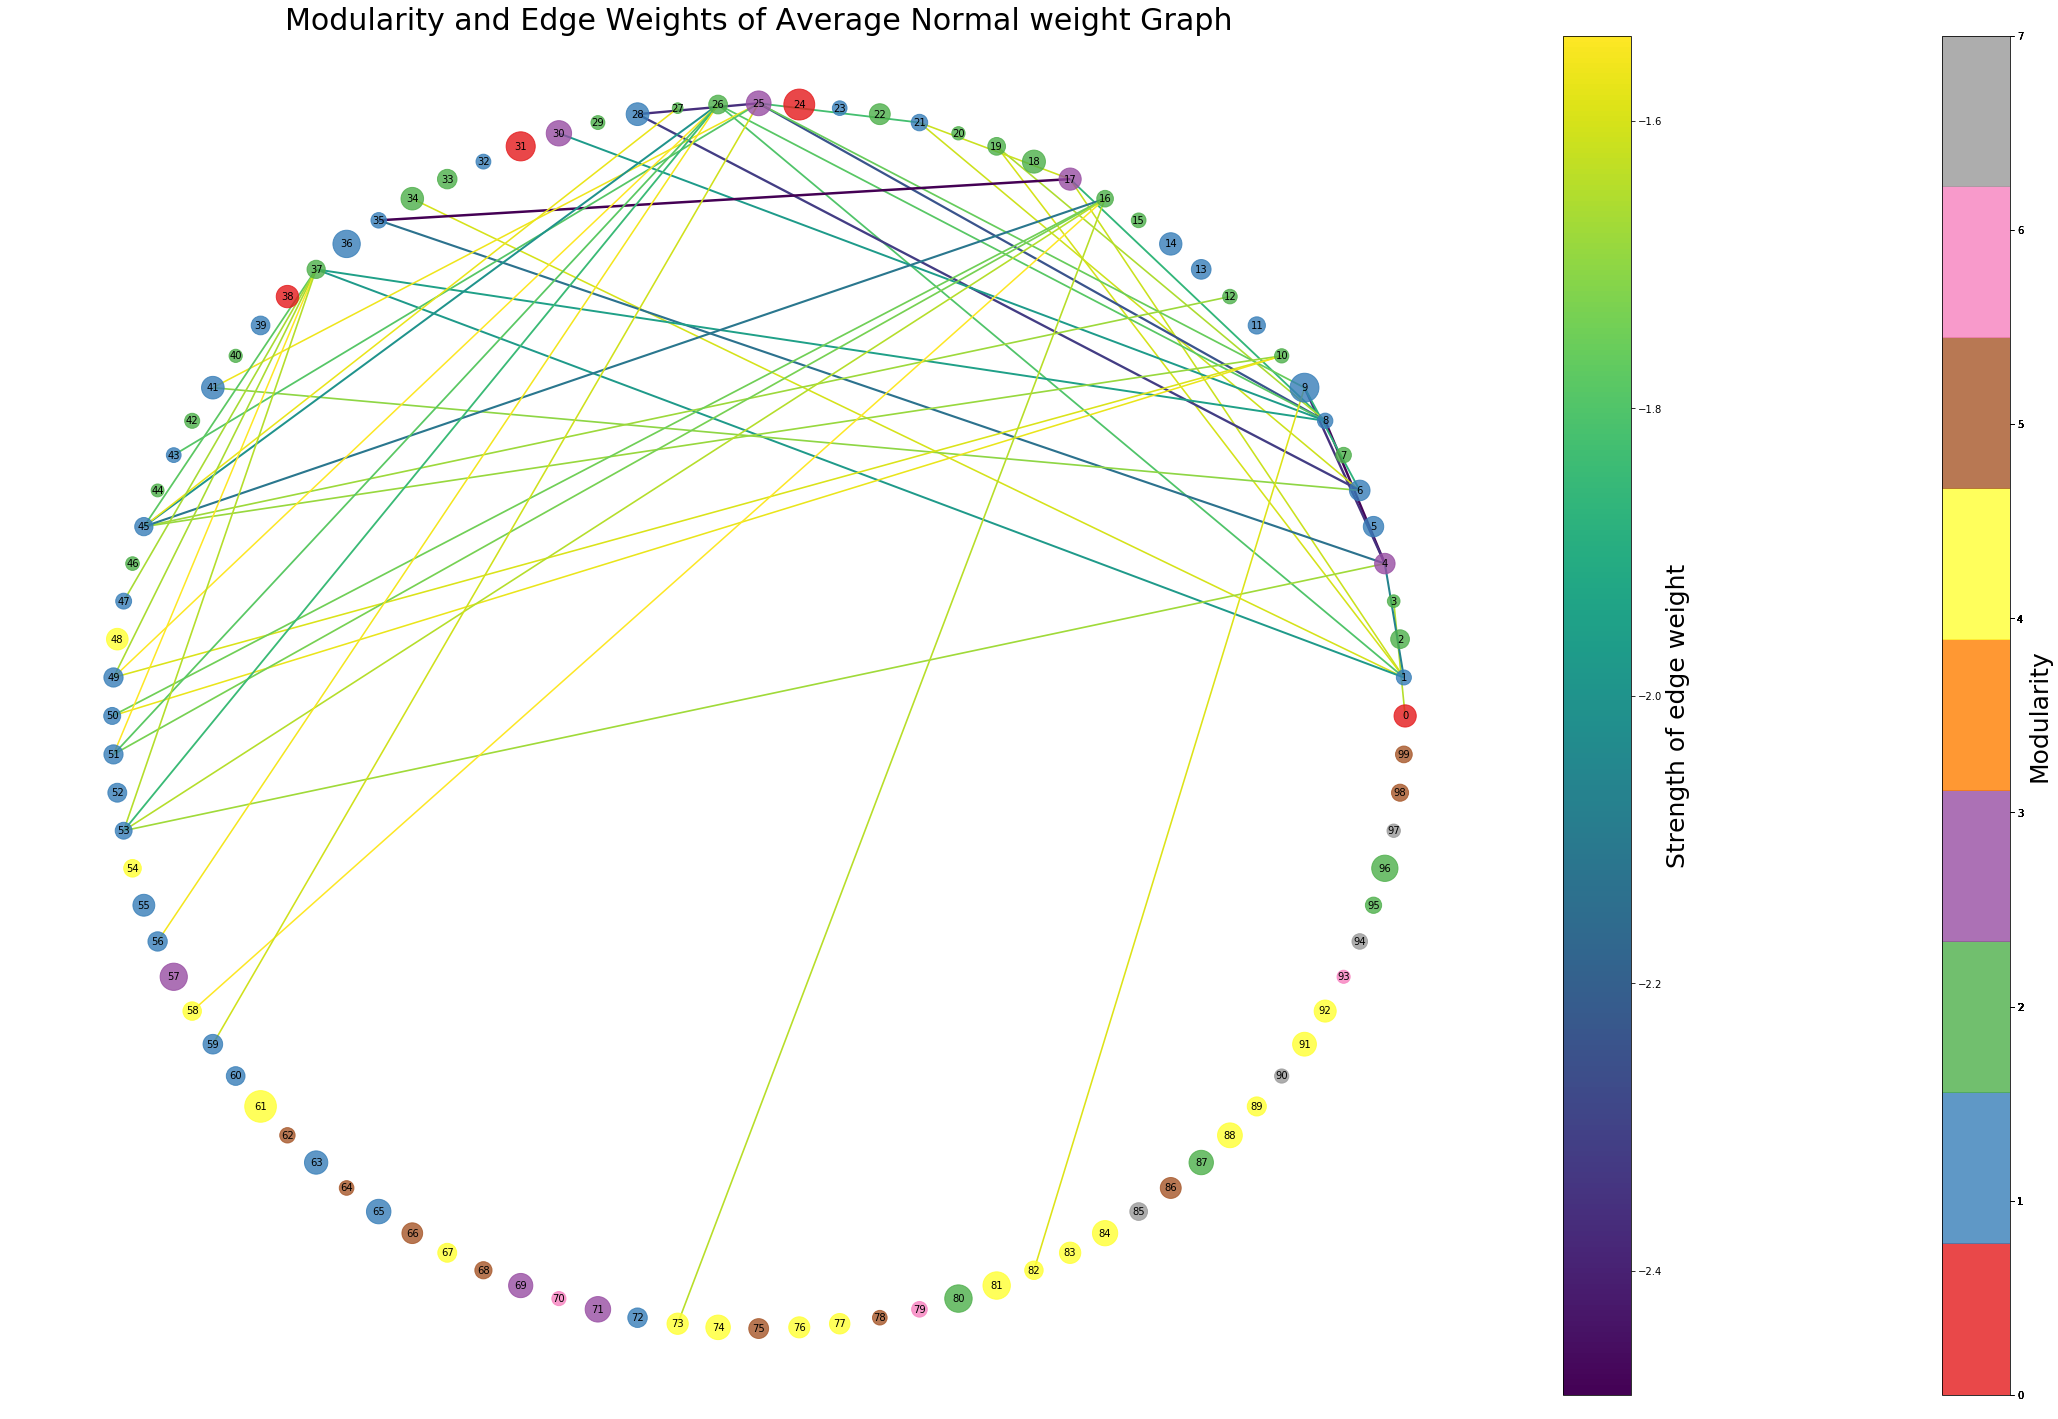

(100,)


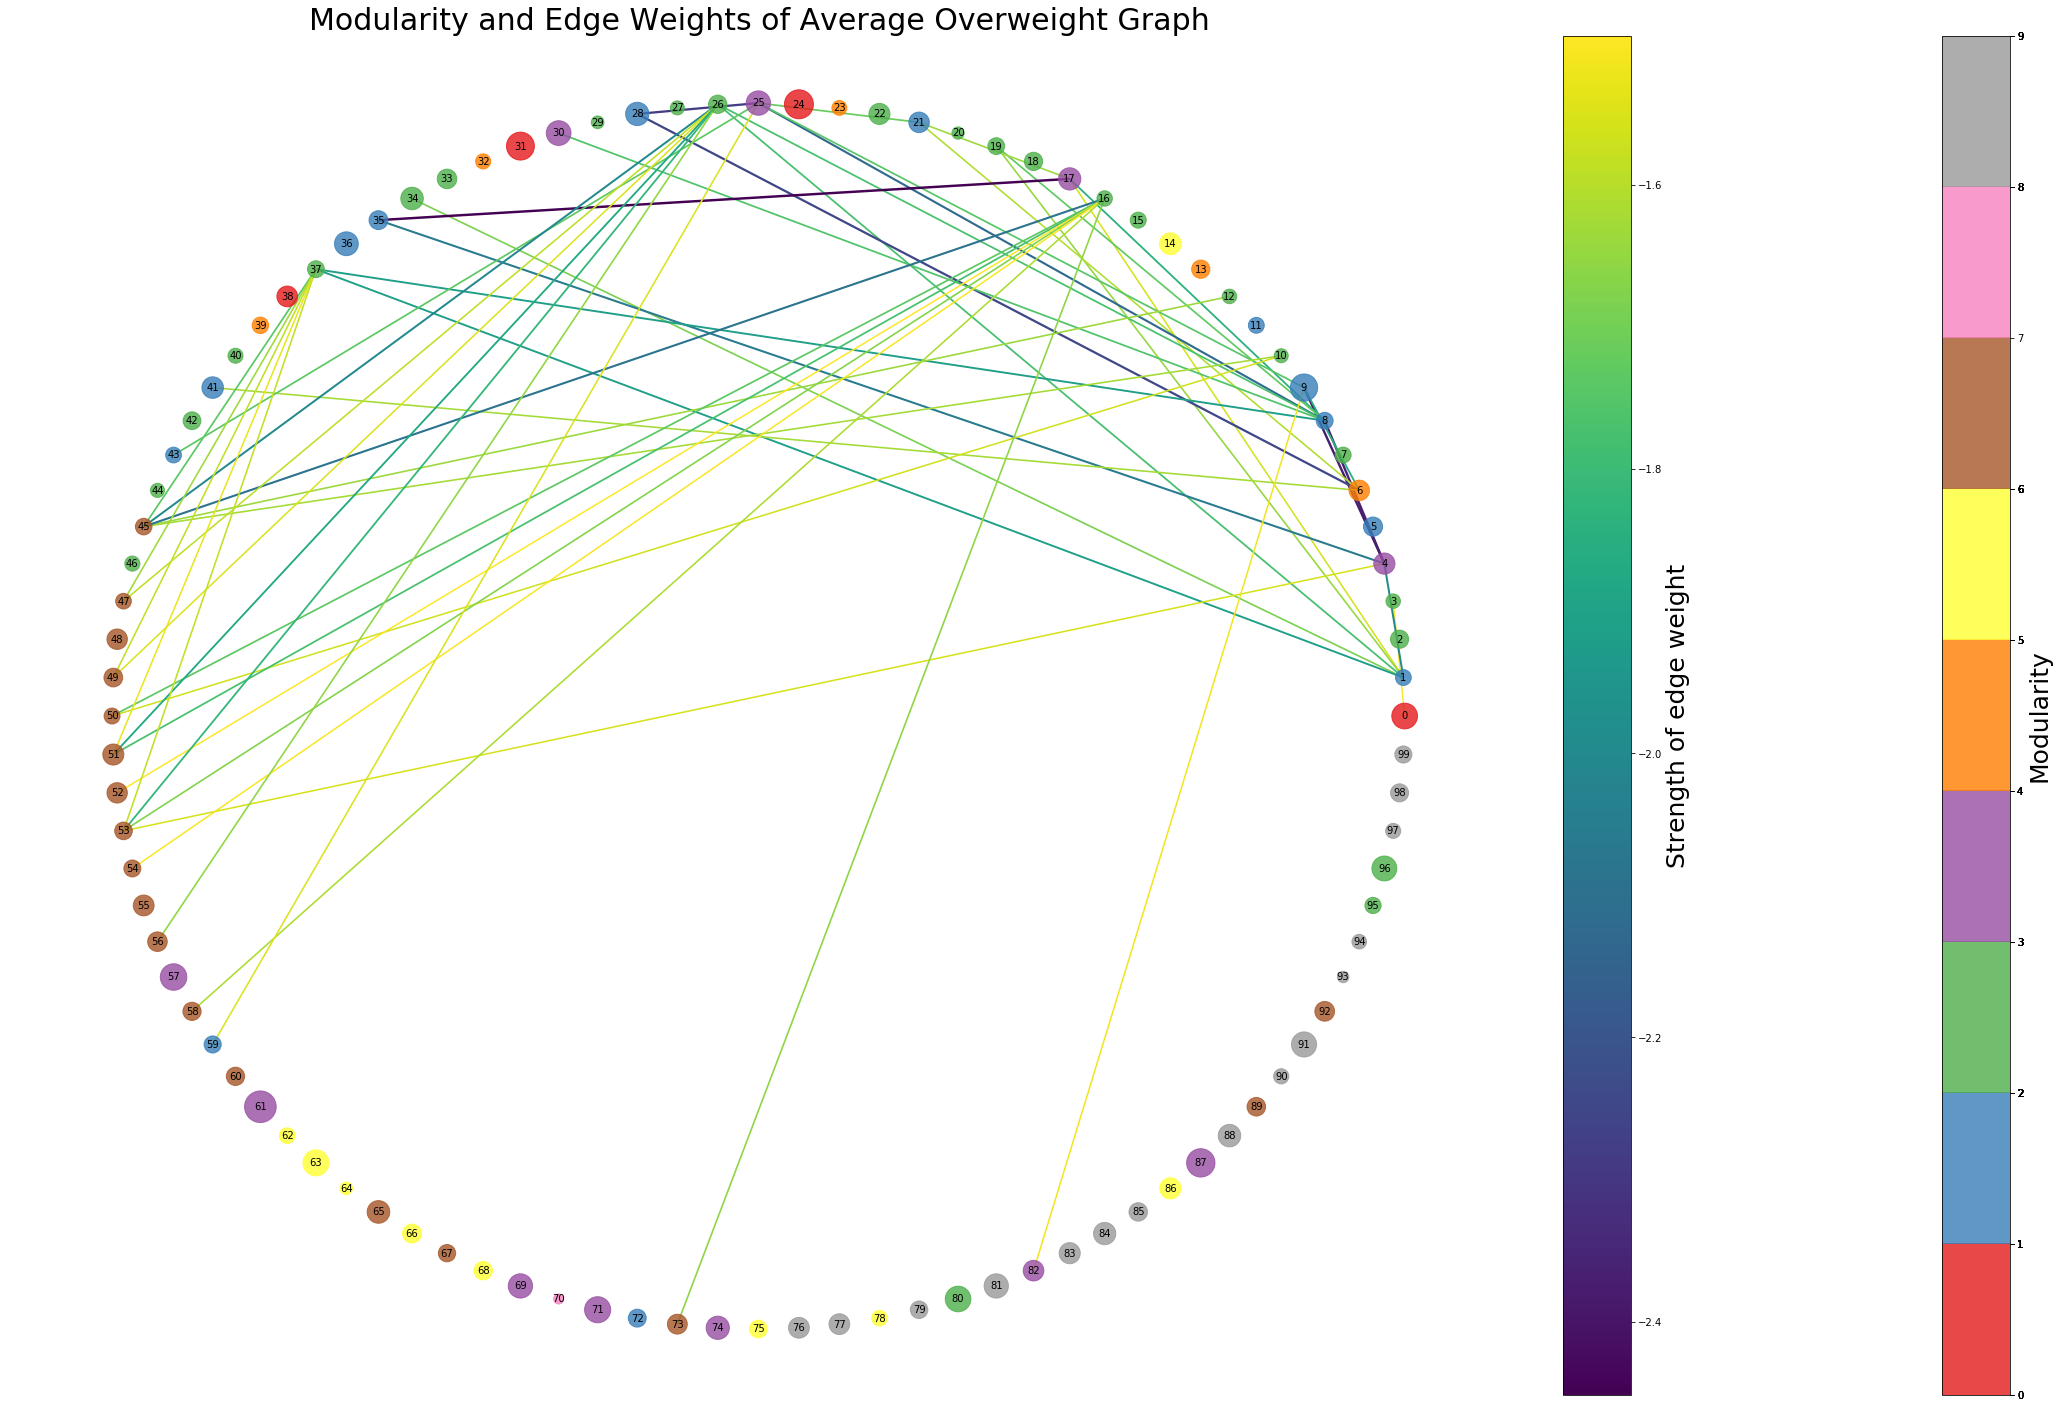

(100,)


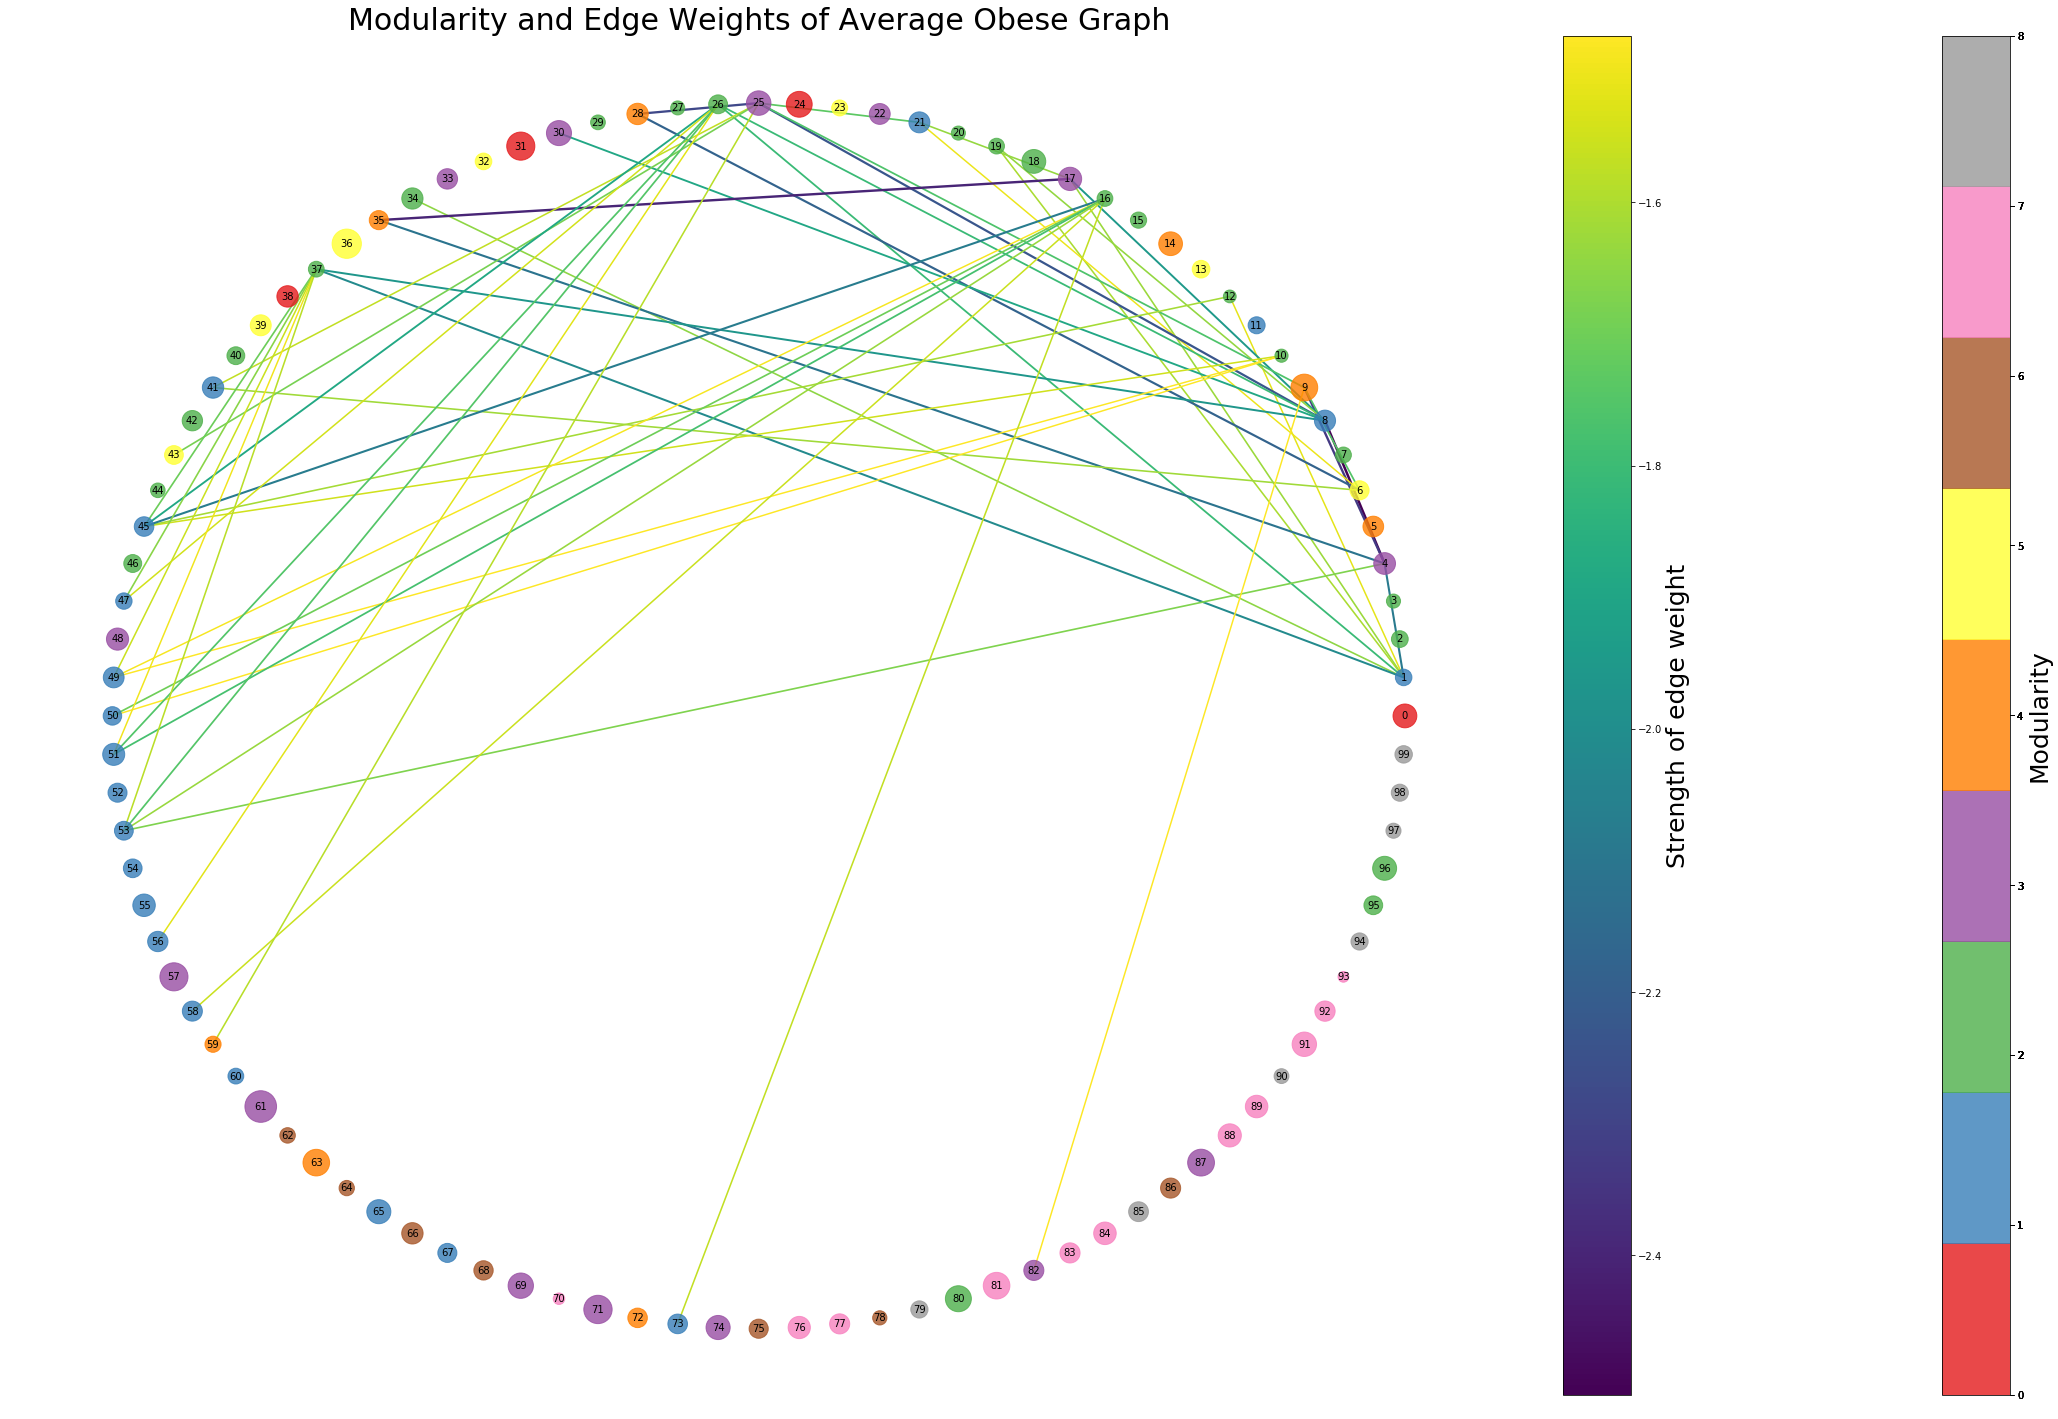

In [2]:
basepath='/Users/gracer/Google Drive/HCP_graph/1200/datasets/'
summary_dict=an.onetoughjar(os.path.join(basepath,'tmp','summary_dict_11-14-2019_04-33-33'))
# dict_keys(['mean_FC', 'graphs', 'clustering_coeff', 'btn_centrality', 'PC', 'modules'])
# summary_dict['NR']['no']['modules']['partition']
summary_dict['NR']['no']['graphs'].nodes(data=True)

an.grace_graph(summary_dict['NR']['no']['graphs'], 'centrality', 'Normal weight', 1)
an.grace_graph(summary_dict['NR']['ov']['graphs'], 'centrality', 'Overweight', 1)
an.grace_graph(summary_dict['NR']['ob']['graphs'], 'centrality', 'Obese', 1)

for key, value in summary_dict.items():
    for k,v in value.items():
        # community.induced_graph(partition dictionary, graph)
         comm_graph = community.induced_graph(v['modules']['partition'], v['graphs'])
         v.update(comm_graph = comm_graph)

(6.839178153846154, 3.15217489102564, -0.499673801282051, -0.1822753782051282, -0.2731012051282051, 0.8566804999999997, 0.004130653846153857, 0.028760711538461534, 83.30720957692309, -81.24788406410248, -17.047357230769222, -2.5415924102564116, 2.36147778846154, 1.325203121794872, 1.2135125128205126, 79.13329968589743, 5.159663147435898, -20.805443564102585, -16.977353051282055, -4.149488698717949, -3.7253519294871786, 11.401580358974359, 6.977510897435895, 1.6970882243589744, -0.3321472051282051, -0.3993100192307692, 32.33031562820511, 4.868985750000001, 1.4330968910256408, 0.20420832692307697, 12.53936955128205, 0.4670076730769231, 0.40087290384615387, 3.1495833846153847, 0.08177813461538458, 4.177454955128205)


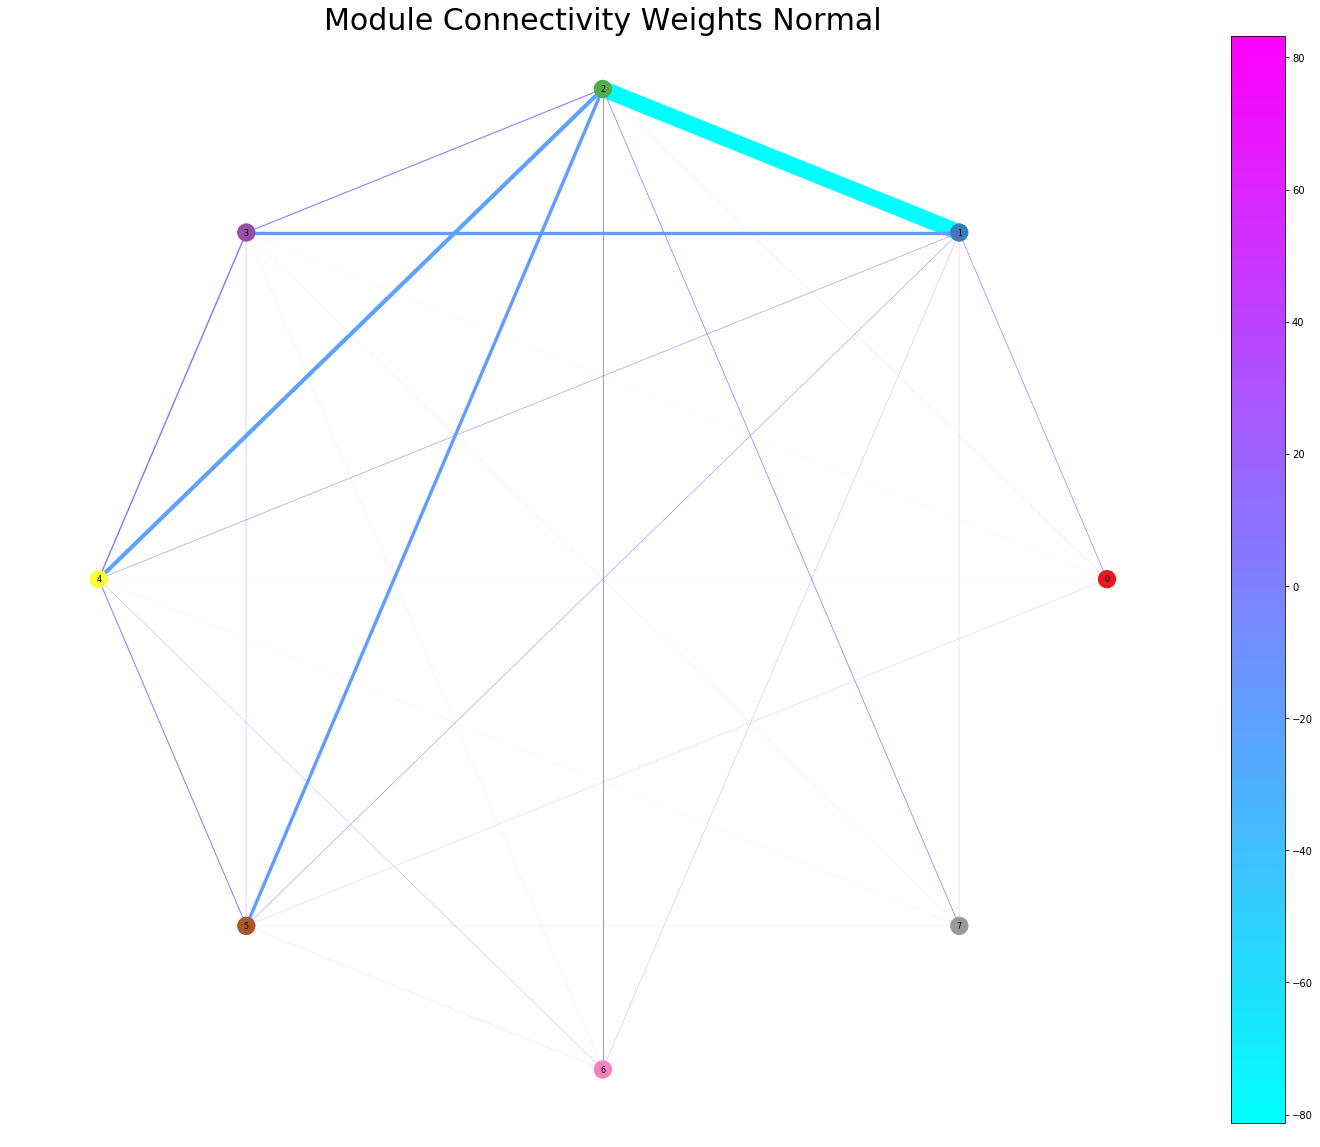

(6.84556090825688, -0.05683406422018366, 0.1391267889908254, -0.39804932110091745, 0.32534517431192655, 1.1608774954128445, 1.4368281651376145, -0.028930366972477063, -0.5018677706422018, 0.13590257798165134, 27.46428903669725, -22.624916394495404, -19.164353348623845, -2.1832950366972486, -2.9421203761467893, 9.809767091743124, -0.09500760550458716, -2.8755670091743126, 0.05398288073394485, 73.52507382568804, 4.336511908256881, -6.9760757431192655, -15.534641128440365, -61.6466267614679, -0.7442177064220183, -5.420048467889905, -7.621981495412842, 18.84315099082569, 1.2153459449541288, 1.7724797339449543, 4.04132047706422, 0.02502941284403669, 2.556288119266056, -0.7505982660550458, 8.652757330275229, 0.8801888807339452, 6.210322678899083, -0.07664171559633026, -1.807665834862385, -0.38780629357798163, 12.750973018348624, 6.855714605504589, -0.09450966972477064, 0.6436166605504587, 1.1561909816513765, 46.52787523853212, 0.40694694495412836, 5.6411689541284415, 2.8062223119266054, 1.0,

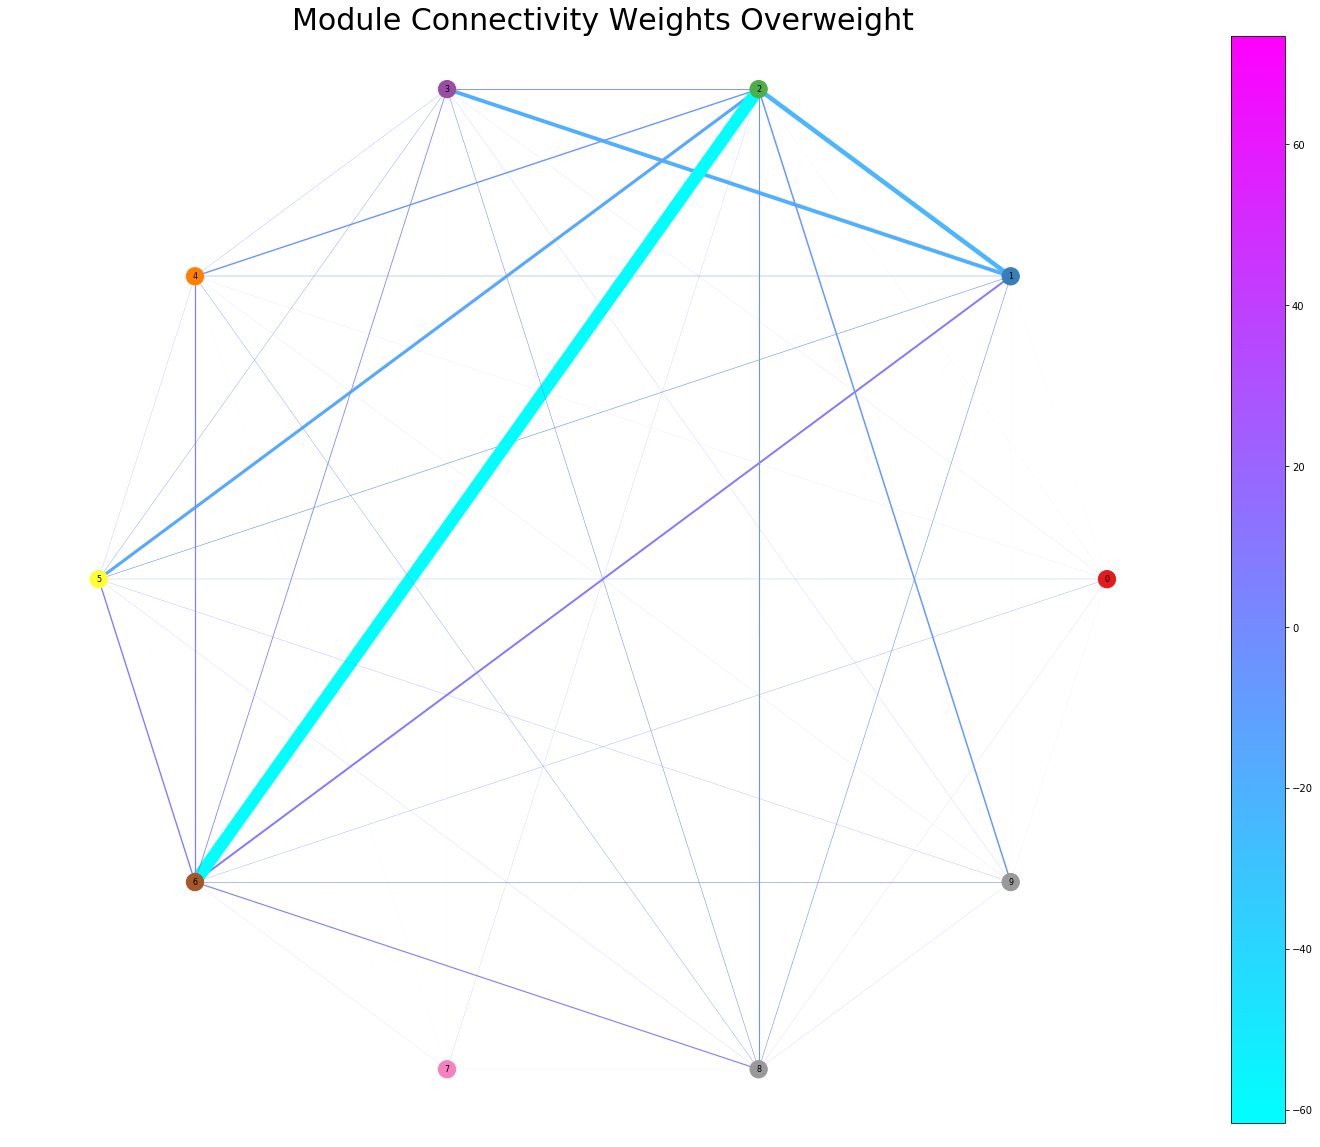

(6.65795508974359, 0.9875995384615381, 1.3216813589743581, 0.01585375641025631, 0.2652431282051283, 0.20460096153846155, 0.5071846153846155, -0.6466515, -0.040346384615384596, 56.76909293589743, -65.40462910256412, -10.553656589743587, 7.152836320512822, 7.3683165769230765, 2.665096987179487, 5.571837269230769, 2.80931323076923, 66.34960338461538, 6.792939384615385, -7.396142910256408, -7.8237058461538425, -9.619678987179487, -7.691797192307698, -6.915172782051281, 25.788076641025633, -12.208356897435891, 0.01835952564102536, 1.1874714102564108, 5.308464807692308, -1.3203558205128205, 11.622262192307693, -0.995417525641026, -1.568936025641026, -3.2681841538461542, -0.03507542307692304, 11.773469884615384, 0.10190924358974347, -3.537429782051283, -0.8151457051282052, 9.47471153846154, 0.29680861538461545, 0.5852464102564103, 15.218294243589742, 0.6245408717948717, 7.624126641025642)


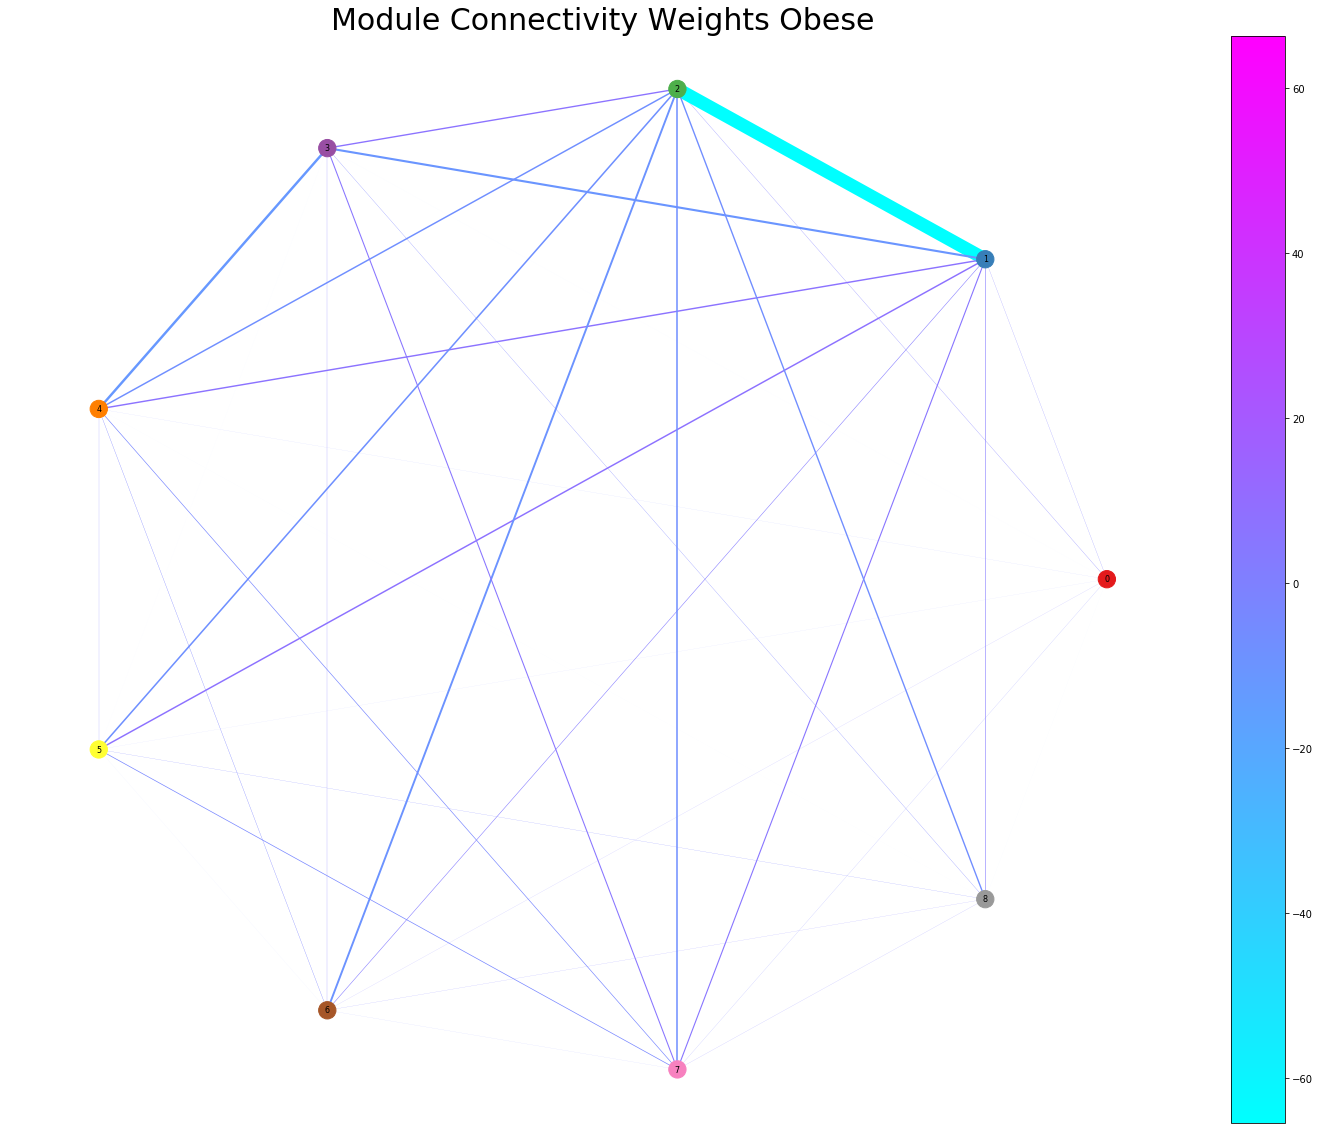

In [3]:
an.module_fig(summary_dict['NR']['no']['comm_graph'], 'Normal')
an.module_fig(summary_dict['NR']['ov']['comm_graph'], 'Overweight')
an.module_fig(summary_dict['NR']['ob']['comm_graph'], 'Obese')

# Full graph metrics

In [4]:
basepath='/Users/gracer/Google Drive/HCP_graph/1200/datasets/'
#Load data from pickle if needed
save_dict=an.onetoughjar(os.path.join(basepath,'tmp','save_dict_11-14-2019_02-46-01'))

In [148]:
save_dict['NR']['no']['mean_FC']

{'101107': 0.1339344348,
 '101309': 0.12331098419999999,
 '101915': 0.1511904184,
 '102109': 0.16005652399999998,
 '102715': 0.10526525060000001,
 '105620': 0.10857012340000001,
 '105923': 0.1394338172,
 '107321': 0.10915908199999999,
 '109830': 0.100304769,
 '110411': 0.13407698759999997,
 '111716': 0.111650353,
 '112112': 0.1588160278,
 '113619': 0.1269339068,
 '114318': 0.12242134819999999,
 '114823': 0.11050210999999999,
 '117122': 0.14766558500000002,
 '117324': 0.1176119698,
 '120414': 0.17605297520000002,
 '120717': 0.1480664674,
 '122317': 0.1286683776,
 '122620': 0.1151433156,
 '125222': 0.10519963040000001,
 '128127': 0.1312906442,
 '129634': 0.12120287639999999,
 '130013': 0.1026909328,
 '130821': 0.1440698818,
 '131419': 0.11704066480000001,
 '132017': 0.1336613004,
 '135225': 0.170839295,
 '135629': 0.15381952019999998,
 '137027': 0.1279259306,
 '138231': 0.0921576956,
 '138332': 0.1387622808,
 '138534': 0.1741862438,
 '138837': 0.1737130838,
 '140319': 0.12276843600000002

In [128]:
stat_dict={'MZ':{'mean_FC':{'no':{},'ov':{},'ob':{}}, 'clustering_coeff':{'no':{},'ov':{},'ob':{}}, 'btn_centrality':{'no':{},'ov':{},'ob':{}}, 'PC':{'no':{},'ov':{},'ob':{}}},
           'DZ':{'mean_FC':{'no':{},'ov':{},'ob':{}}, 'clustering_coeff':{'no':{},'ov':{},'ob':{}}, 'btn_centrality':{'no':{},'ov':{},'ob':{}}, 'PC':{'no':{},'ov':{},'ob':{}}},
           'NR':{'mean_FC':{'no':{},'ov':{},'ob':{}}, 'clustering_coeff':{'no':{},'ov':{},'ob':{}}, 'btn_centrality':{'no':{},'ov':{},'ob':{}}, 'PC':{'no':{},'ov':{},'ob':{}}}}

In [152]:
stat_dict={'MZ':{'mean_FC':{'no':{},'ov':{},'ob':{}}, 'clustering_coeff':{'no':{},'ov':{},'ob':{}}, 'btn_centrality':{'no':{},'ov':{},'ob':{}}, 'PC':{'no':{},'ov':{},'ob':{}}},
           'DZ':{'mean_FC':{'no':{},'ov':{},'ob':{}}, 'clustering_coeff':{'no':{},'ov':{},'ob':{}}, 'btn_centrality':{'no':{},'ov':{},'ob':{}}, 'PC':{'no':{},'ov':{},'ob':{}}},
           'NR':{'mean_FC':{'no':{},'ov':{},'ob':{}}, 'clustering_coeff':{'no':{},'ov':{},'ob':{}}, 'btn_centrality':{'no':{},'ov':{},'ob':{}}, 'PC':{'no':{},'ov':{},'ob':{}}}}
for key, value in save_dict.items():
#     print(key)
    for subkey,subval in value.items():
#         print(subkey)
        for k,v in subval.items():
#             print('loop 1')
            if k in ['mean_FC','clustering_coeff','btn_centrality','PC']:
#                 print(k)
                stat_dict[key][k][subkey]=pd.DataFrame.from_dict(v, 'index')
                new_name=[]
                for item in list(stat_dict[key][k][subkey].columns[0:100]):
                    new_name.append('IC_%s'%(item+1))
                stat_dict[key][k][subkey].columns=new_name
                stat_dict[key][k][subkey]['group'] = subkey

for key, value in stat_dict.items():
    print(key)
    for k,v in value.items():
        print(k)
        df = pd.concat([v['no'],v['ov']], axis=0)
        df = pd.concat([df,v['ob']], axis=0)
        if k in ['clustering_coeff', 'btn_centrality', 'PC']:
            keys = []
            tables = []
            for variable in list(df.columns)[0:100]:
                m='%s ~ group'%variable
                model = ols(m, data=df).fit()
                anova_table = sm.stats.anova_lm(model, typ=2)

                keys.append(variable)
                tables.append(anova_table)

            df_anova = pd.concat(tables, keys=keys, axis=0)
            raw_p=df_anova['PR(>F)'].dropna()
            fdr=st.stats.multitest.fdrcorrection(raw_p, alpha=0.05, method='indep', is_sorted=False)
            stat_dict[key][k].update({'full':df, 'anova':df_anova, 'FDR':fdr})
        else:
            print(df)
            keys = []
            tables = []
#             pdb.set_trace()
            variable='IC_1'
            m='%s ~ group'%variable
            model = ols(m, data=df).fit()
            anova_table = sm.stats.anova_lm(model, typ=2)

            keys.append(variable)
            tables.append(anova_table)

            df_anova = pd.concat(tables, keys=keys, axis=0)
            raw_p=df_anova['PR(>F)'].dropna()
            fdr=st.stats.multitest.fdrcorrection(raw_p, alpha=0.05, method='indep', is_sorted=False)
            stat_dict[key][k].update({'full':df, 'anova':df_anova, 'FDR':fdr})



MZ
mean_FC
            IC_1 group
249947  0.123241    no
320826  0.123197    no
133019  0.159211    no
112516  0.115233    no
127226  0.116614    no
263436  0.138891    no
627549  0.117324    no
125525  0.118286    no
765864  0.111834    no
757764  0.171420    no
145632  0.100389    no
154835  0.108050    no
469961  0.112633    no
176542  0.139871    no
141422  0.097345    no
149337  0.109614    no
164636  0.102235    no
186848  0.113350    no
901442  0.125120    no
181232  0.115732    no
135528  0.118888    no
150928  0.137909    no
901139  0.157763    no
166438  0.124930    no
135124  0.196596    no
148941  0.132776    no
852455  0.110750    no
165436  0.098587    no
547046  0.124511    no
463040  0.171820    no
...          ...   ...
198249  0.108021    ob
116524  0.120936    ob
512835  0.112078    ob
555348  0.118418    ob
200614  0.144112    ob
159340  0.138192    ob
178243  0.145965    ob
103010  0.131726    ob
110007  0.120140    ob
182436  0.105733    ob
149741  0.101710    ob


In [174]:
stat_dict['NR'].keys()

dict_keys(['mean_FC', 'clustering_coeff', 'btn_centrality', 'PC'])

In [172]:
for key, value in stat_dict.items():
    for subkey,subval in value.items():
        for k,v in subval.items():
            if k == 'FDR':
                s = set(v[0])
                if True in s:
                    print('there is a significant value here %s %s'%(key,subkey))
                    print(stat_dict[key][subkey]['FDR'][1])
                    print(stat_dict[key][subkey]['anova'])
                

there is a significant value here MZ btn_centrality
[0.90448581 0.04252094 0.97360975 0.97360975 0.75707025 0.96015913
 0.97360975 0.97360975 0.7713951  0.75707025 0.96015913 0.97360975
 0.68327733 0.97360975 0.82736513 0.72009073 0.68327733 0.87604892
 0.96015913 0.66612122 0.66612122 0.72009073 0.66612122 0.66612122
 0.68327733 0.82736513 0.97360975 0.96015913 0.86827437 0.96015913
 0.96015913 0.96015913 0.7713951  0.90122326 0.82736513 0.66612122
 0.69381972 0.68327733 0.97360975 0.04252094 0.96015913 0.69381972
 0.97360975 0.68327733 0.96015913 0.66612122 0.97360975 0.66612122
 0.68133241 0.97360975 0.66612122 0.96015913 0.86827437 0.66612122
 0.66612122 0.7713951  0.66612122 0.66612122 0.96015913 0.96015913
 0.90122326 0.96864494 0.97360975 0.82736513 0.98352413 0.96015913
 0.66612122 0.69381972 0.72009073 0.41558267 0.97360975 0.66612122
 0.96015913 0.96015913 0.97360975 0.66612122 0.68133241 0.72009073
 0.87665472 0.95107221 0.66612122 0.66612122 0.97360975 0.49408425
 0.9601591

In [180]:
df=stat_dict['MZ']['btn_centrality']['full']
m='%s ~ group'%'IC_2'
model = ols(m, data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   IC_2   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     7.682
Date:                Fri, 15 Nov 2019   Prob (F-statistic):           0.000580
Time:                        15:37:40   Log-Likelihood:                 1245.7
No. Observations:                 251   AIC:                            -2485.
Df Residuals:                     248   BIC:                            -2475.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0039      0.000     23.995      0.000       0.004       0.004
group[T.ob]     0.0010      0.000      3.444      0.001       0.000       0.002
group[T.ov]    -0.0001      0.000     -0.459      0.646      -0.001       0.000
==============================================================================
Omnibus:                      220.901   Durbin-Watson:                   1.614
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6941.837
Skew:                           3.244   Prob(JB):                         0.00
Kurtosis:                      27.933   Cond. No.                         3.50
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Did not find any differences in the nodal metrics between groups in the not related condition  
IC_2 shows significantly different betweenness centrality between the obese and normal weight monozygotic twin subset. Probably due to a false discovery 

In [181]:
an.adillyofapickle('/Users/gracer/Google Drive/HCP_graph/1200/datasets',stat_dict,'6_stat_dict')

already have tmp


## Checking functional connectivity 

In [4]:
def plot_matrices(matrices, matrix_kind):
    n_matrices = len(matrices)
    fig = plt.figure(figsize=(n_matrices * 4, 4))
    for n_subject, matrix in enumerate(matrices):
        plt.subplot(1, n_matrices, n_subject + 1)
        matrix = matrix.copy()  # avoid side effects
        # Set diagonal to zero, for better visualization
        np.fill_diagonal(matrix, 0)
        vmax = np.max(np.abs(matrix))
        title = '{0}, subject {1}'.format(matrix_kind, n_subject)
        plotting.plot_matrix(matrix, vmin=-vmax, vmax=vmax, cmap='RdBu_r',
                             title=title, figure=fig, colorbar=False)
        


In [5]:
basepath='/Users/gracer/Google Drive/HCP_graph/1200/datasets/'
file_dict=an.onetoughjar(os.path.join(basepath,'tmp','file_dict_11-13-2019_06-28-29'))


In [6]:
file_dict['NR']['ov']['134223']

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,0.210895,-0.024323,-0.437263,0.087980,-0.041669,0.155948,-0.208165,-0.025456,-0.218968,...,0.032779,0.023945,0.121837,0.041737,0.001337,-0.141942,-0.009214,-0.010274,0.140704,0.111232
1,0.210895,1.000000,-0.094325,-0.393739,-0.390576,0.031429,0.189119,-0.210074,0.260218,0.059511,...,-0.013609,-0.025346,-0.023367,0.024470,-0.011215,-0.109371,-0.105407,0.006409,0.132225,0.057145
2,-0.024323,-0.094325,1.000000,0.321559,-0.116166,-0.048147,-0.231077,0.625136,-0.030891,0.117839,...,0.020783,-0.019014,-0.138838,0.024835,0.029653,0.072787,0.019078,0.057004,-0.047755,-0.023312
3,-0.437263,-0.393739,0.321559,1.000000,0.052480,-0.040853,-0.279834,0.554754,-0.062108,0.215117,...,-0.000765,-0.039072,-0.136351,-0.028720,0.034859,0.140537,0.056254,0.039166,-0.182362,-0.166184
4,0.087980,-0.390576,-0.116166,0.052480,1.000000,-0.098338,0.002122,-0.043814,-0.365139,-0.196375,...,0.011843,-0.043775,0.017875,0.001697,-0.009651,0.009316,0.030054,0.001459,-0.090486,-0.073389
5,-0.041669,0.031429,-0.048147,-0.040853,-0.098338,1.000000,-0.150238,-0.122532,0.363919,0.639860,...,-0.052572,-0.046715,-0.130609,-0.040785,0.002957,0.073609,0.065284,0.033632,-0.083753,-0.070229
6,0.155948,0.189119,-0.231077,-0.279834,0.002122,-0.150238,1.000000,-0.350225,-0.223471,-0.424887,...,0.043844,0.119021,0.139396,0.005181,0.013013,-0.059243,-0.034986,-0.031731,0.114129,0.106708
7,-0.208165,-0.210074,0.625136,0.554754,-0.043814,-0.122532,-0.350225,1.000000,-0.108918,0.142979,...,0.031826,-0.062279,-0.217543,0.010028,0.023169,0.116754,0.050592,0.108646,-0.111867,-0.117897
8,-0.025456,0.260218,-0.030891,-0.062108,-0.365139,0.363919,-0.223471,-0.108918,1.000000,0.562070,...,-0.054677,0.010134,-0.014998,-0.029818,-0.029478,-0.039579,-0.100625,-0.073300,-0.053828,-0.045553
9,-0.218968,0.059511,0.117839,0.215117,-0.196375,0.639860,-0.424887,0.142979,0.562070,1.000000,...,-0.054519,-0.104741,-0.183750,-0.061319,-0.006565,0.112320,0.026147,-0.021363,-0.164182,-0.140967


In [7]:
listcorr_dict={'MZ':{'no':[],'ov':[],'ob':[]},'DZ':{'no':[],'ov':[],'ob':[]},'NR':{'no':[],'ov':[],'ob':[]}}
for key, value in file_dict.items():
    for subkey, subval in value.items():
        print(subkey)
        for k,v in subval.items():
            listcorr_dict[key][subkey].append(v.to_numpy())

no
ov
ob
no
ov
ob
no
ov
ob


Correlations of no subjects are stacked in an array of shape {0}
Mean correlation has shape (100, 100).


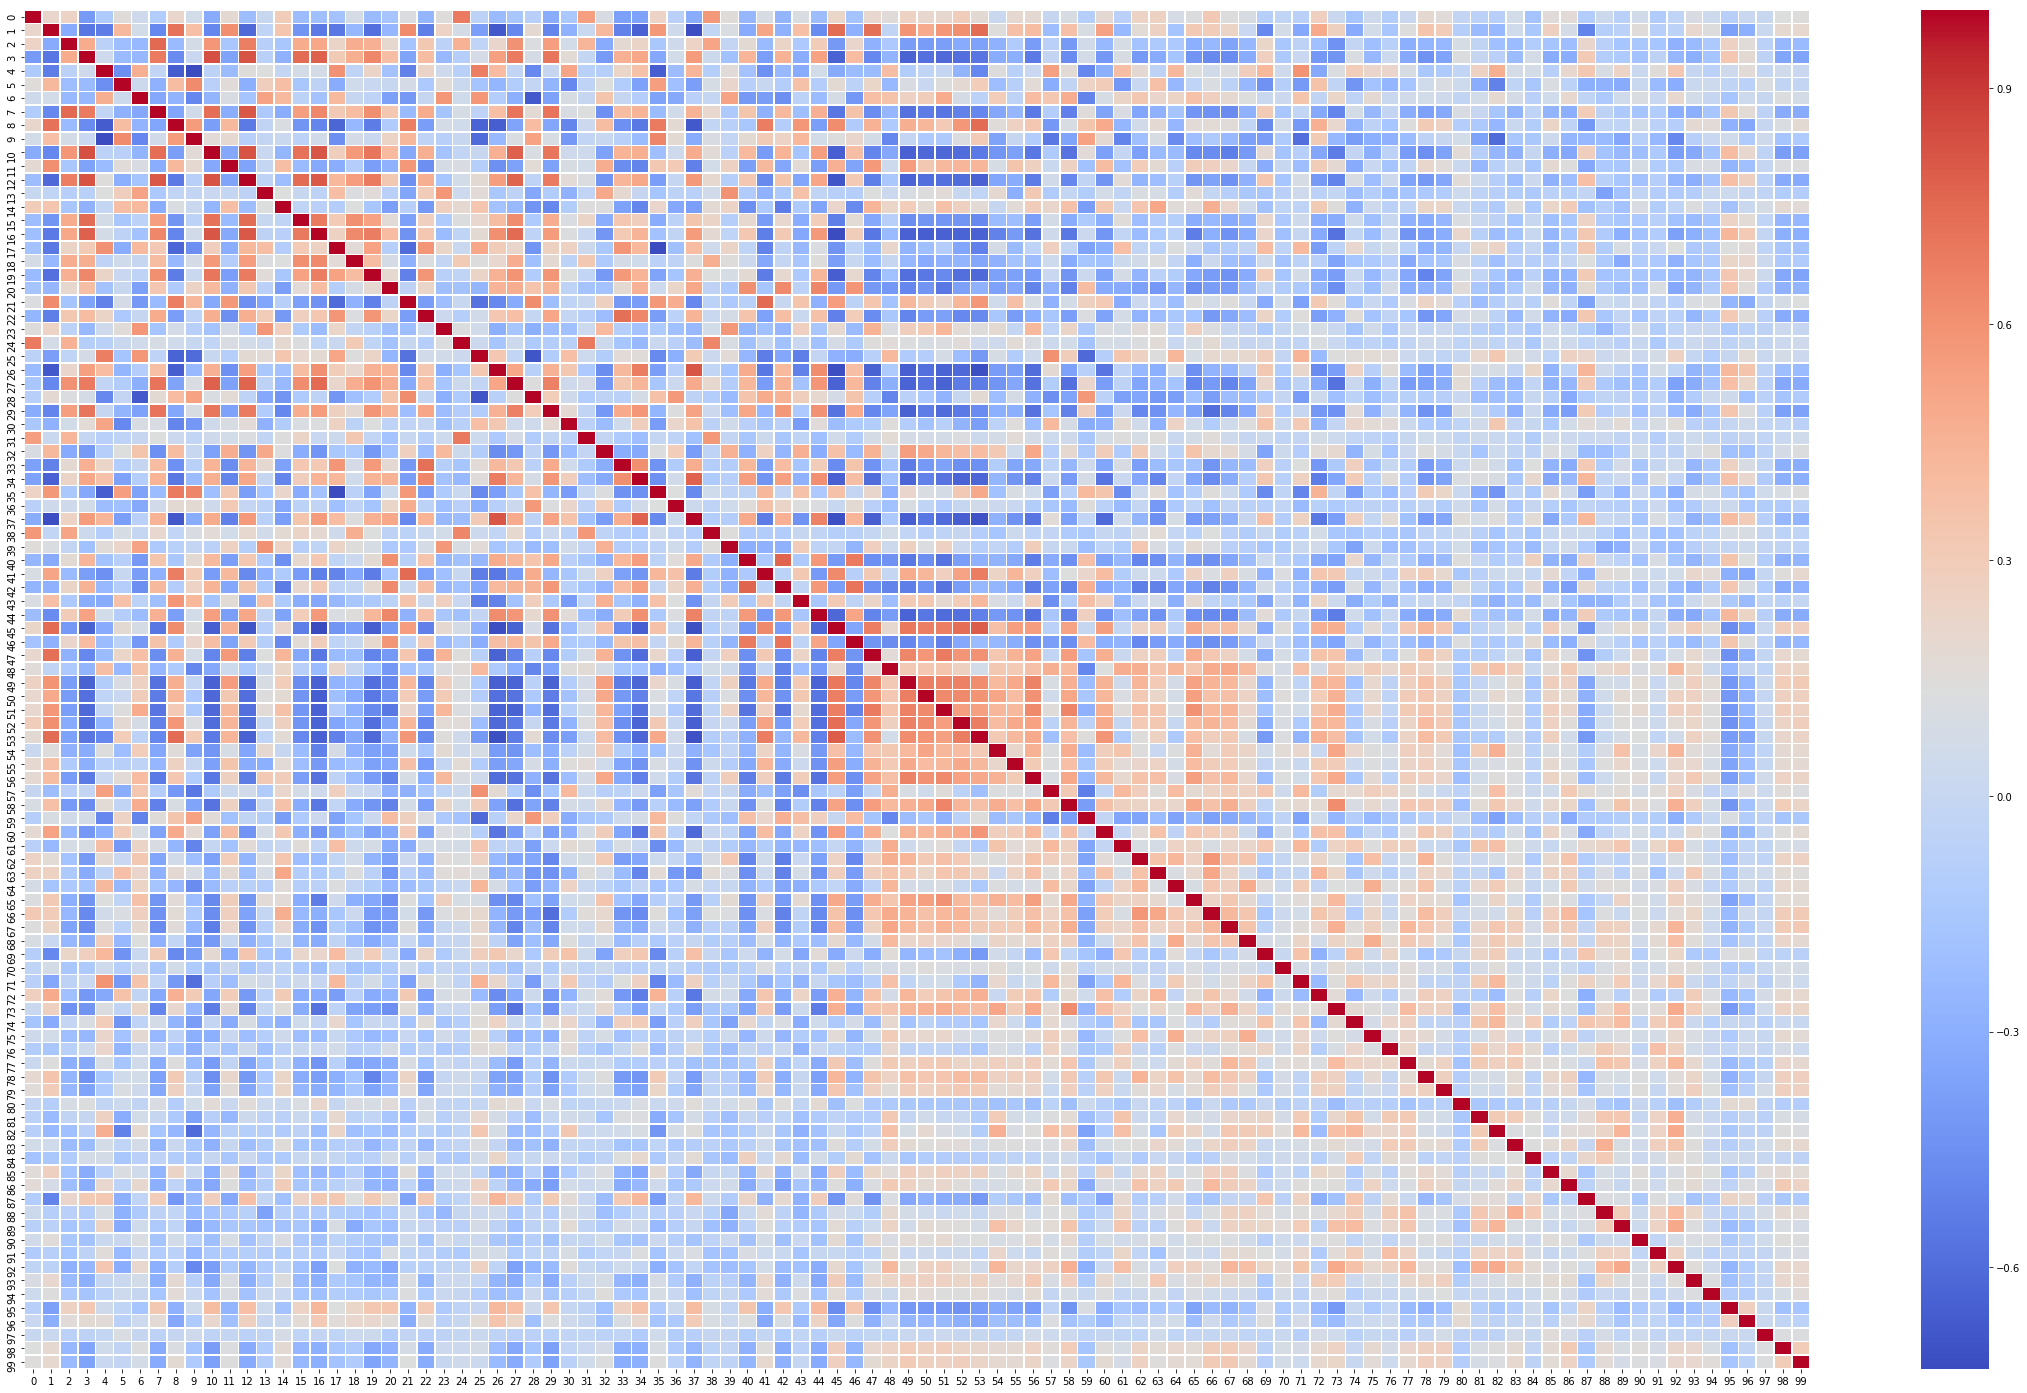

Correlations of ov subjects are stacked in an array of shape {0}
Mean correlation has shape (100, 100).


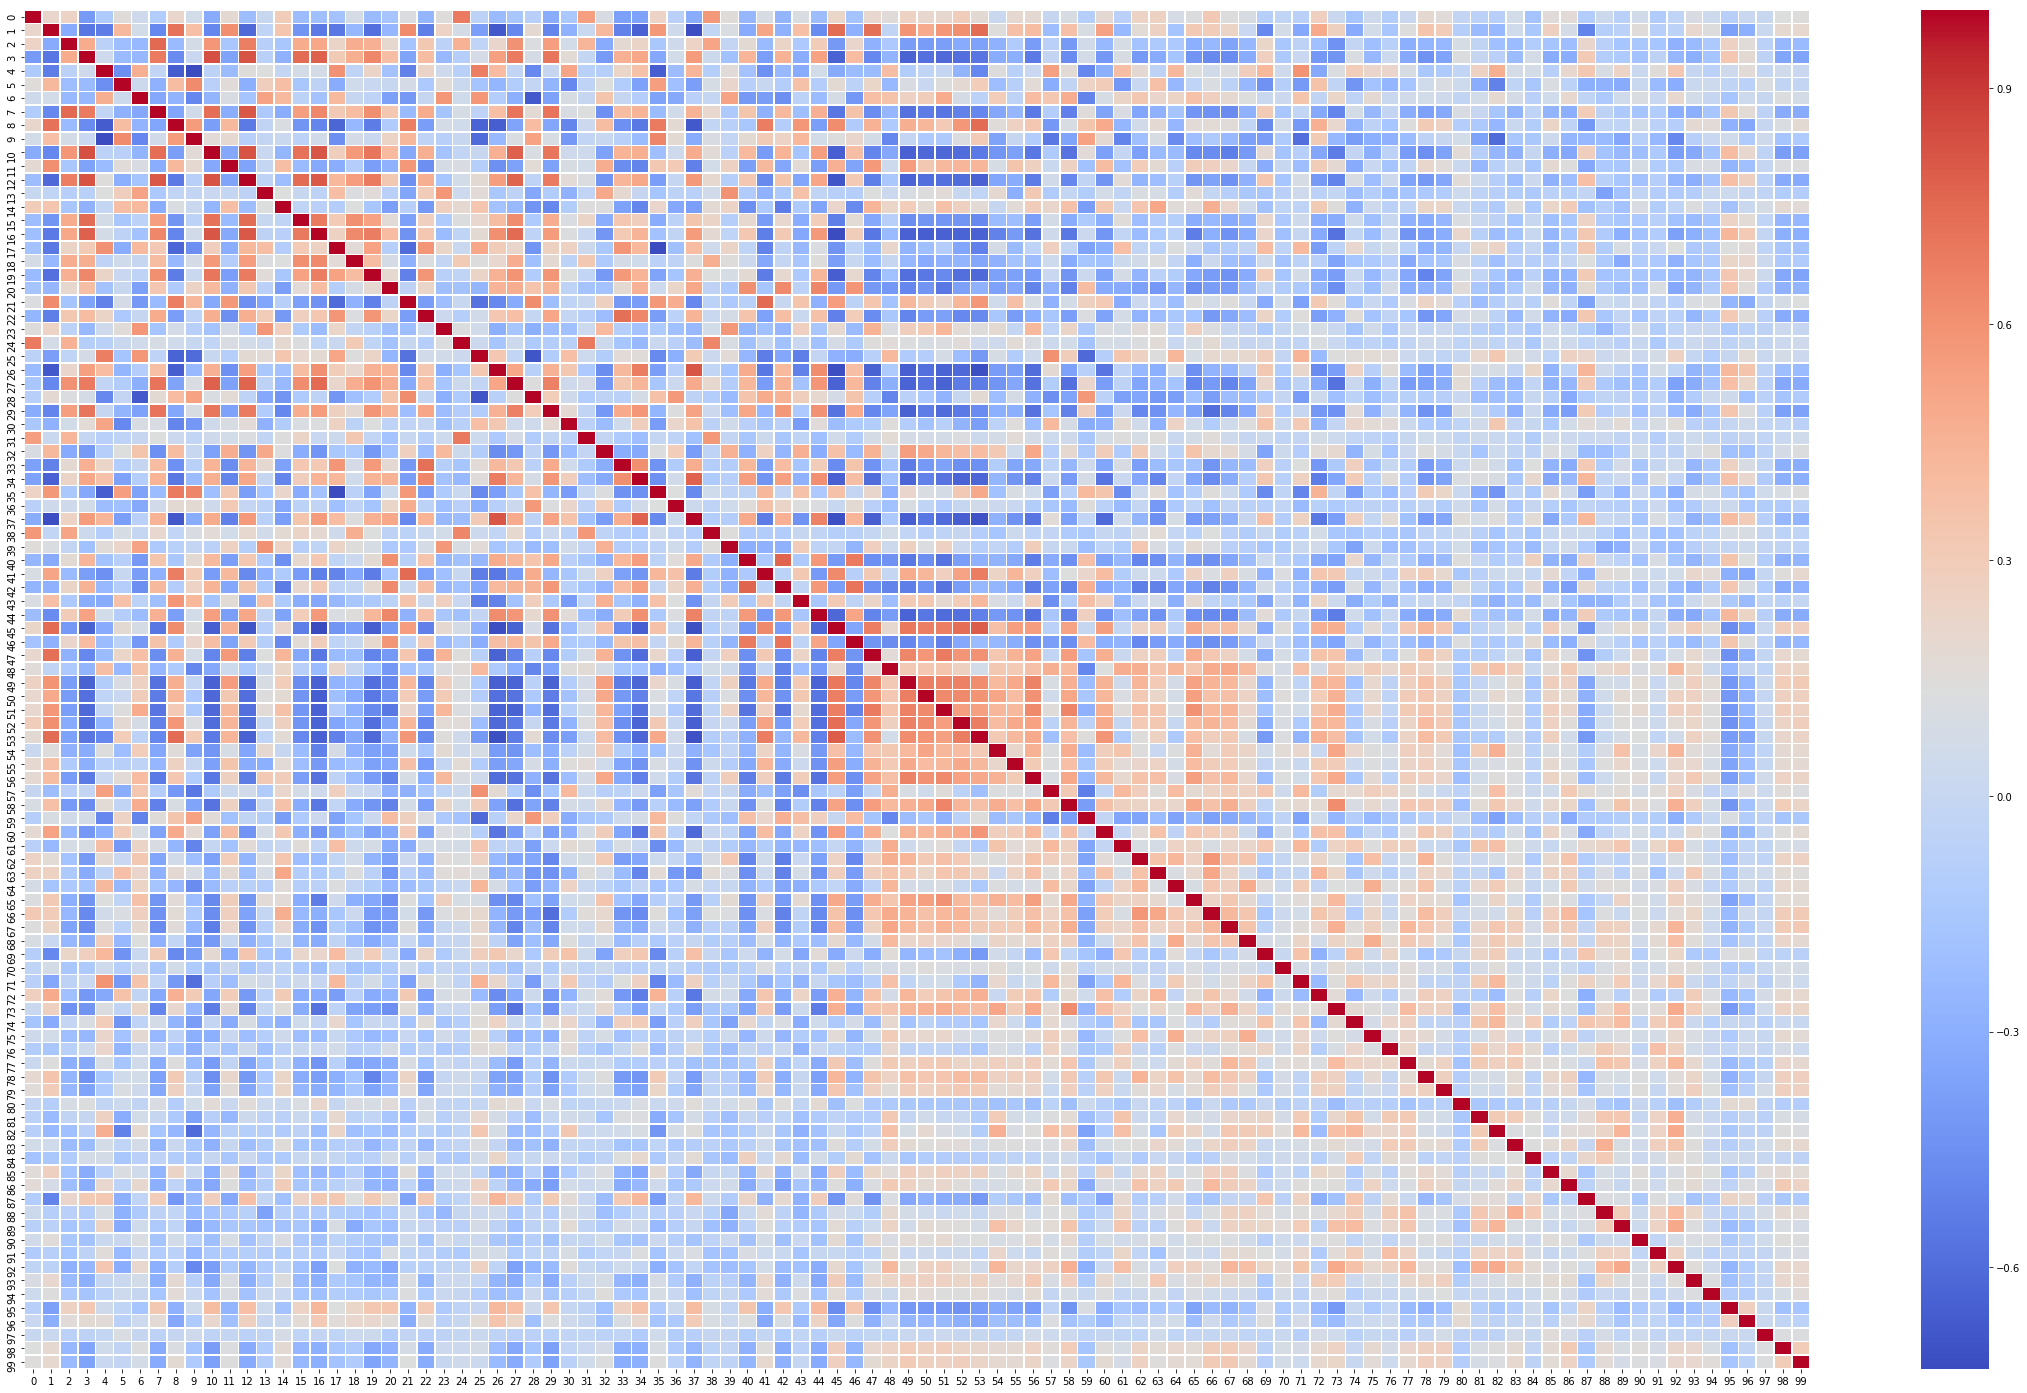

Correlations of ob subjects are stacked in an array of shape {0}
Mean correlation has shape (100, 100).


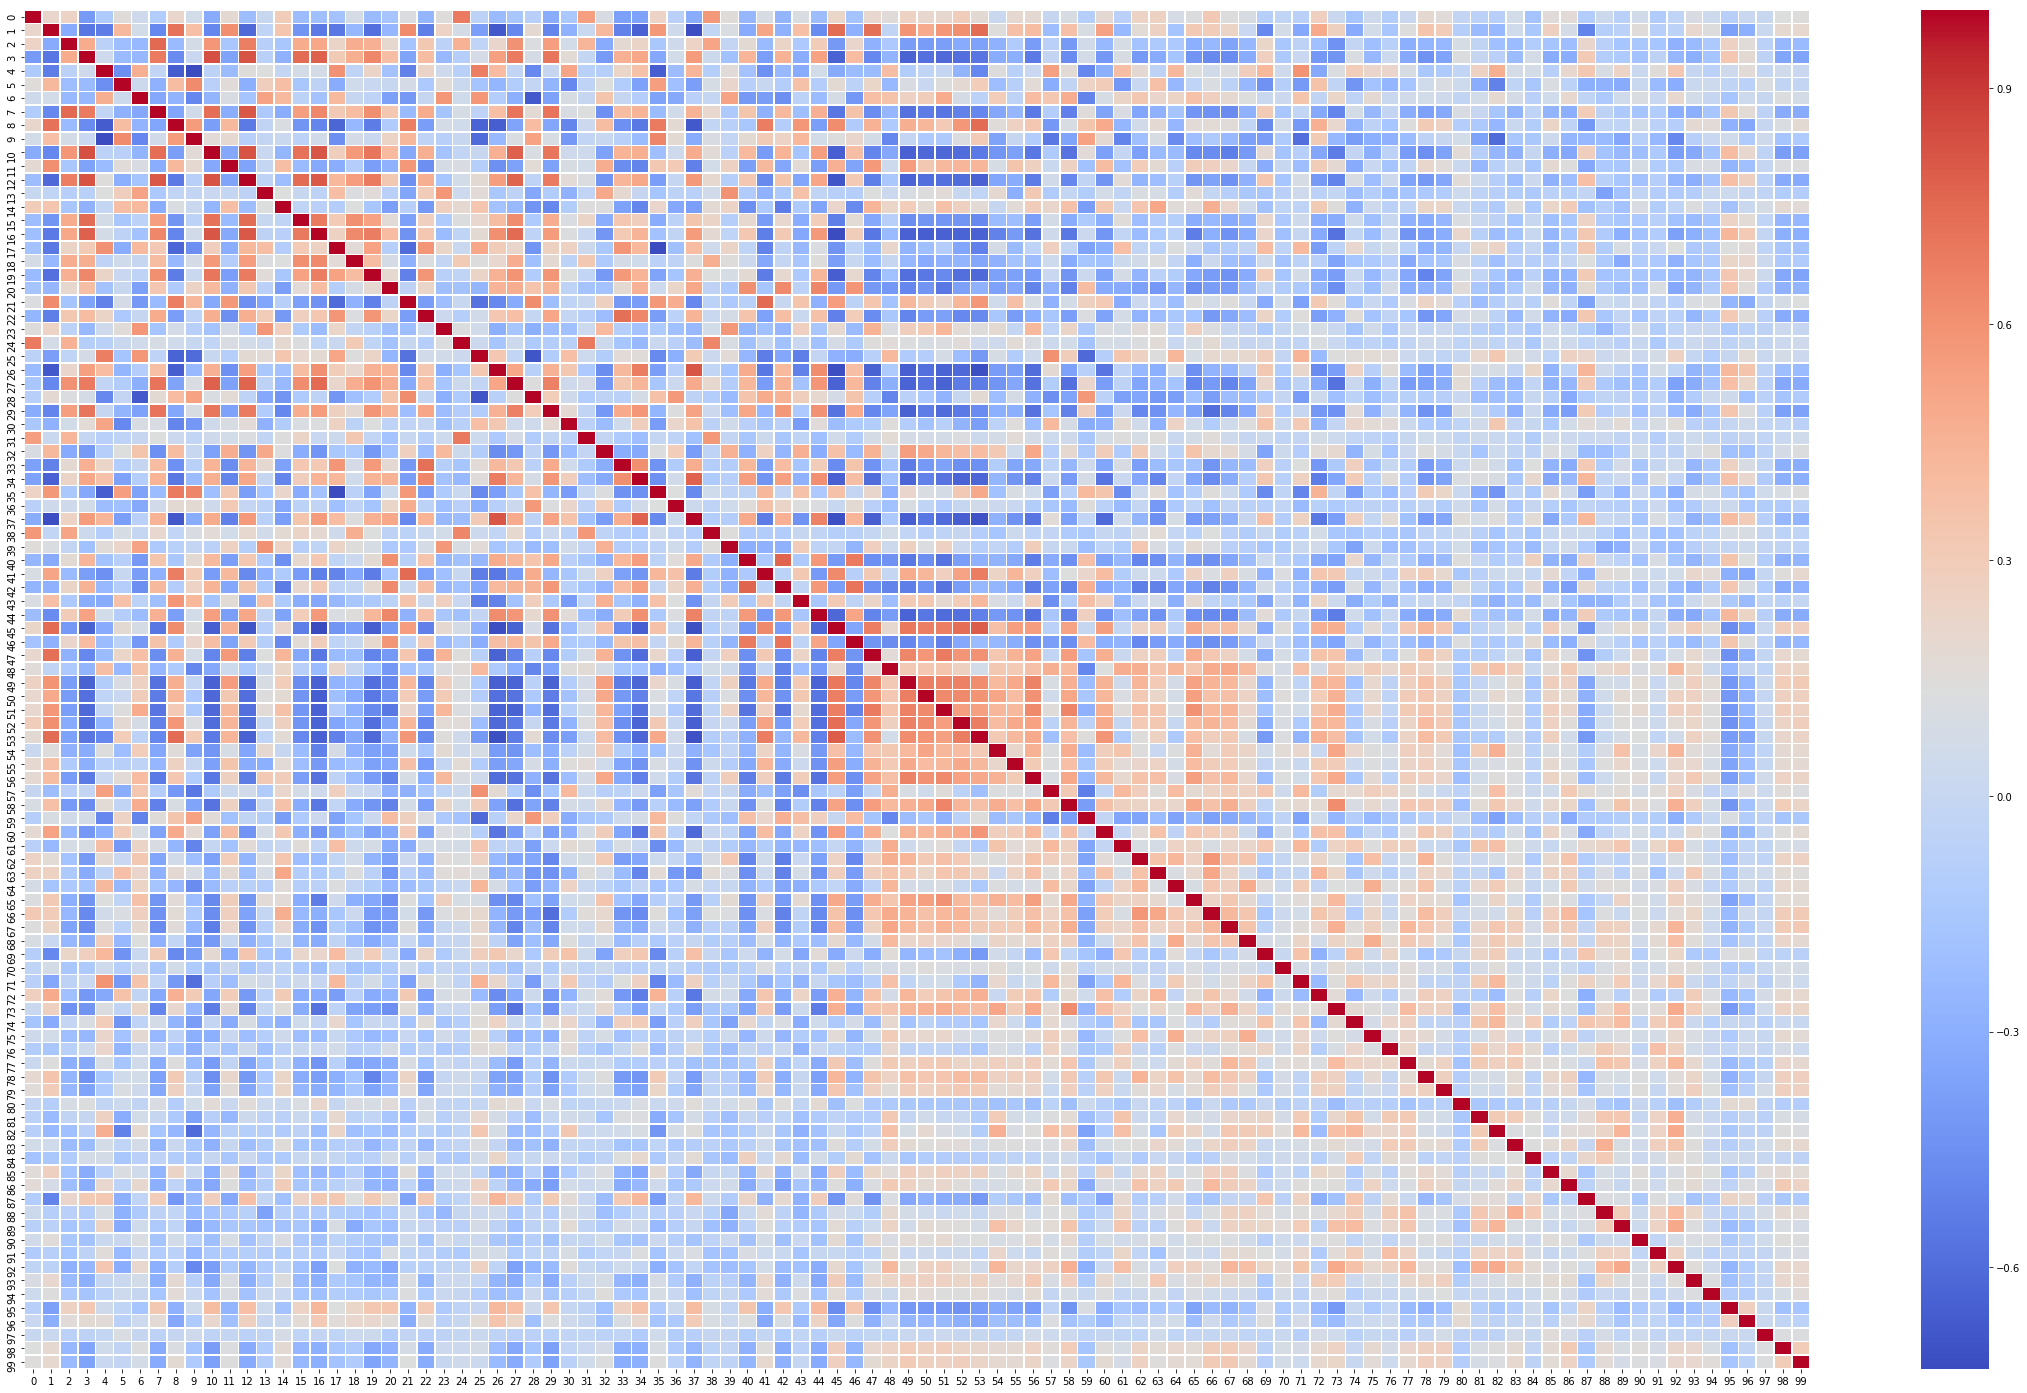

In [13]:
correlation_measure = ConnectivityMeasure(kind='correlation')

for key, value in listcorr_dict['NR'].items():
    correlation_matrices = correlation_measure.fit_transform(value)
    # All individual coefficients are stacked in a unique 2D matrix.
    print('Correlations of %s subjects are stacked in an array of shape {0}'%key
          .format(correlation_matrices.shape))
    rwd_mean_correlation_matrix = rwd_correlation_measure.mean_
    print('Mean correlation has shape {0}.'.format(rwd_mean_correlation_matrix.shape))


    plt.figure(figsize=(40,25))
    ax = sns.heatmap(rwd_mean_correlation_matrix, linewidth=0.5, cmap='coolwarm')

    #Save the figure
    # ax.figure.savefig("/Users/jennygilbert/Documents/betaseries_bevel/reward_coor_mat.png")

    #plot_matrices(rwd_correlation_matrices[:5], 'reward')
    #plot_matrices(rwd_mean_correlation_matrix, 'reward')



    plt.show()
# numpy.savetxt('/Users/jennygilbert/Documents/betaseries_bevel/reward_coor_mat.csv', rwd_mean_correlation_matrix, delimiter=',')


In [28]:
a=listcorr_dict['NR']['no']
b=listcorr_dict['NR']['ov']
c=listcorr_dict['NR']['ob']
results=spy_stats.f_oneway(a, b, c)

In [30]:
results[1]

array([[       nan, 0.05291604, 0.49715283, ..., 0.28084842, 0.63923761,
        0.05866766],
       [0.05291604,        nan, 0.12251363, ..., 0.32825715, 0.31604761,
        0.50558943],
       [0.49715283, 0.12251363,        nan, ..., 0.13036856, 0.28005161,
        0.93999183],
       ...,
       [0.28084842, 0.32825715, 0.13036856, ...,        nan, 0.24441807,
        0.09663881],
       [0.63923761, 0.31604761, 0.28005161, ..., 0.24441807,        nan,
        0.08466696],
       [0.05866766, 0.50558943, 0.93999183, ..., 0.09663881, 0.08466696,
               nan]])

In [31]:
fdr=st.stats.multitest.fdrcorrection(results[1], alpha=0.05, method='indep', is_sorted=False)

/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/stats/multitest.py:320: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals_sorted <= ecdffactor*alpha
/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/stats/multitest.py:328: RuntimeWarning: invalid value encountered in greater
  pvals_corrected[pvals_corrected>1] = 1


### Between no and ov & no and ob
p=0.05/2  
p=0.025

/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


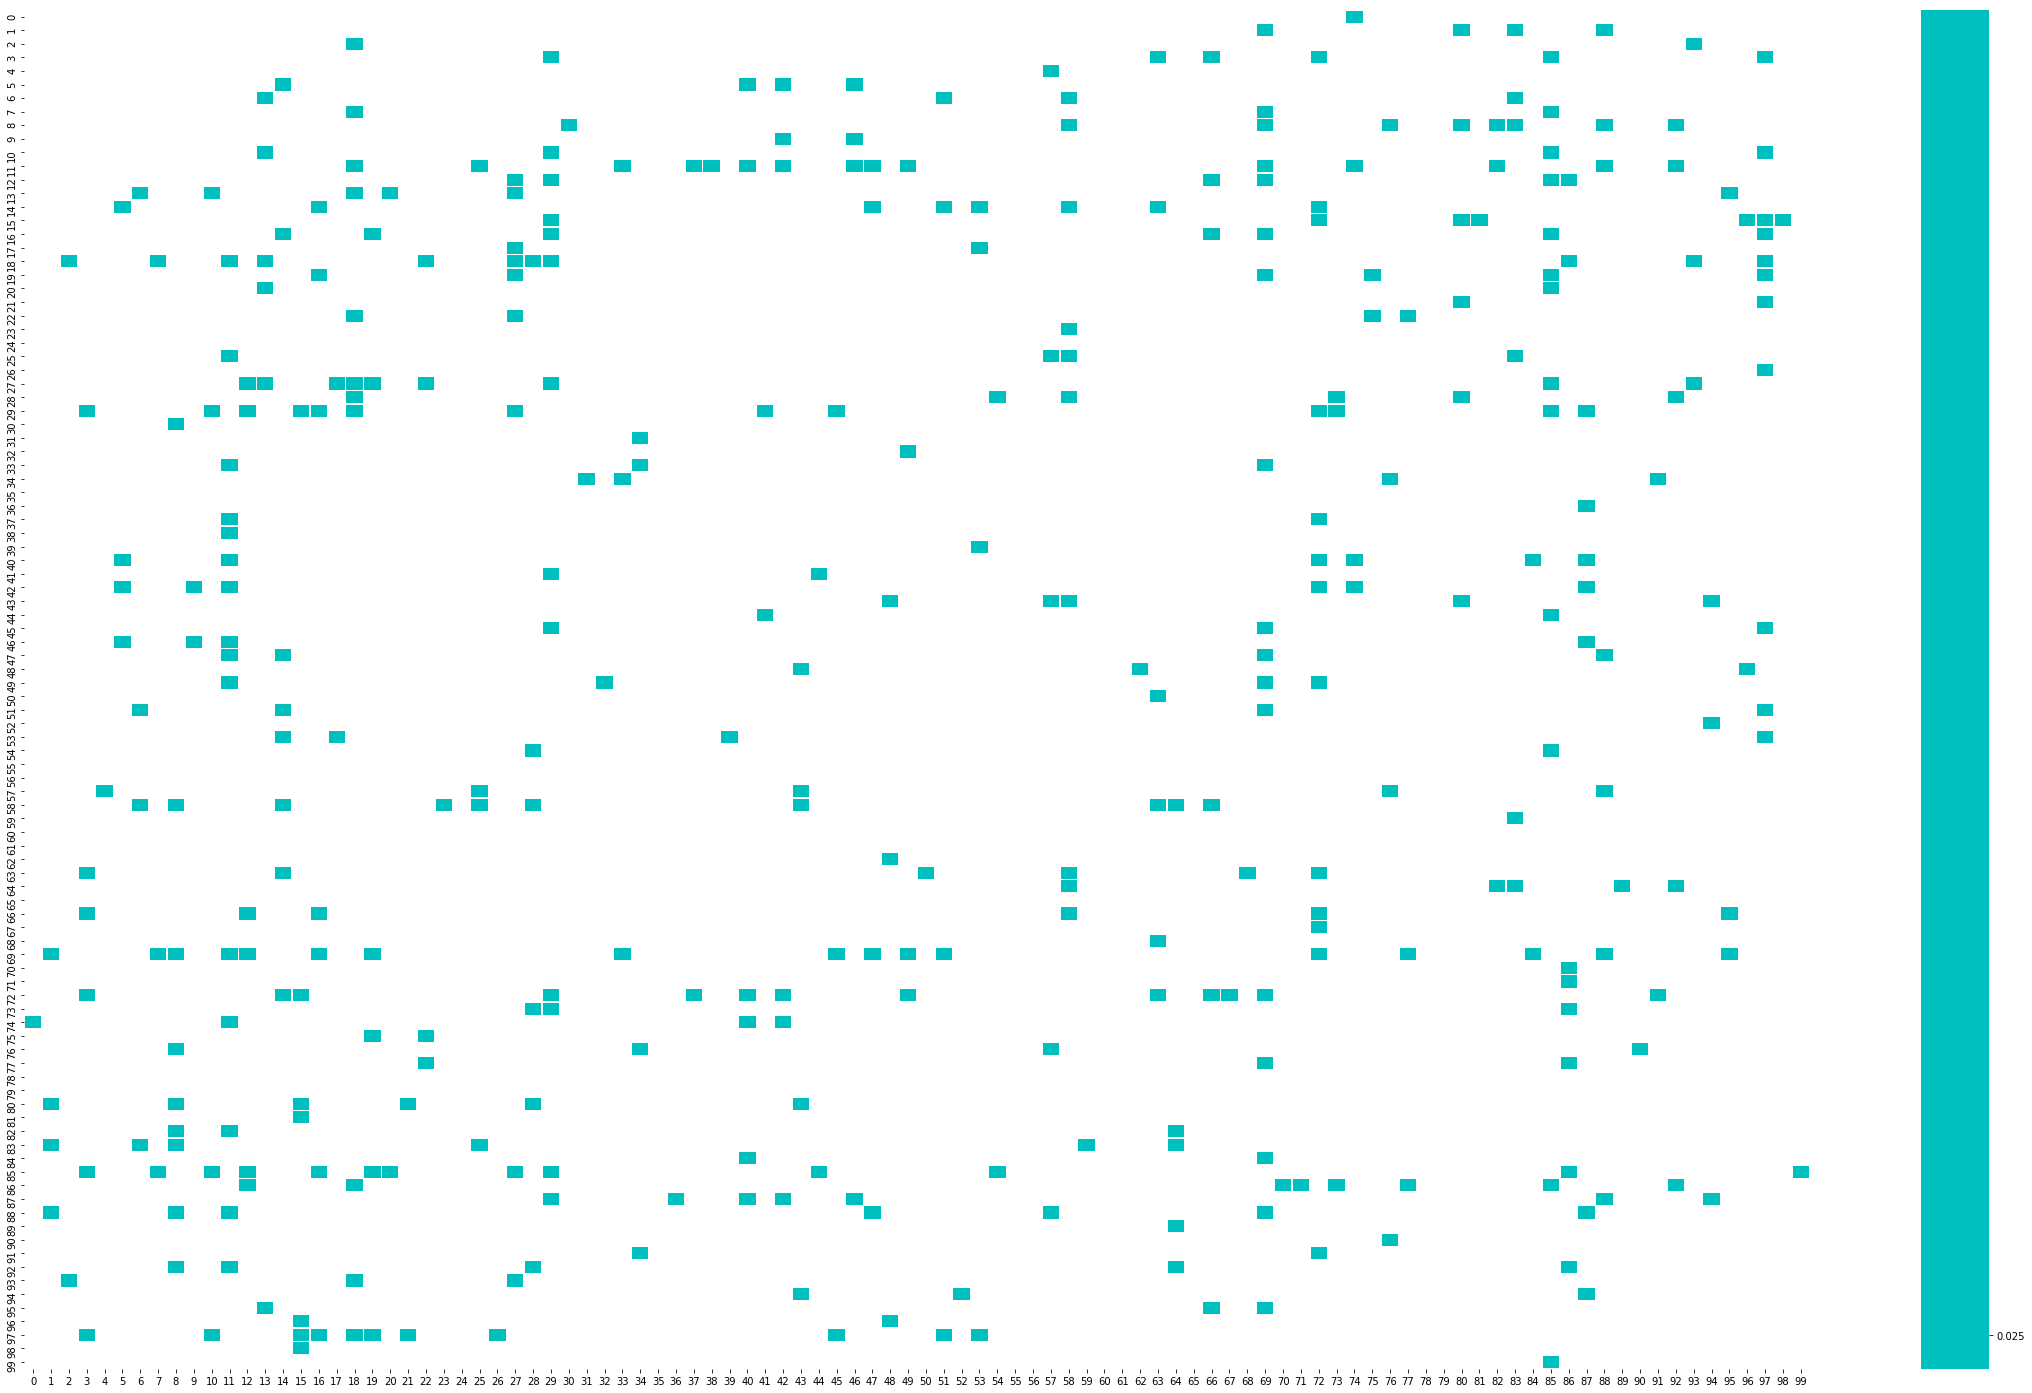

(100, 100)


In [112]:
no_ov=spy_stats.ttest_ind(a, b, nan_policy='omit')
# print(no_ov[1])
coor_fig(no_ov[1])
print(no_ov[1].shape)
# no_ov_fdr=st.stats.multitest.fdrcorrection(no_ov[1], alpha=0.025, method='indep', is_sorted=False)
# coor_fig(no_ov_fdr[1])

/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/stats/multitest.py:320: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals_sorted <= ecdffactor*alpha
/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/stats/multitest.py:328: RuntimeWarning: invalid value encountered in greater
  pvals_corrected[pvals_corrected>1] = 1
/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid

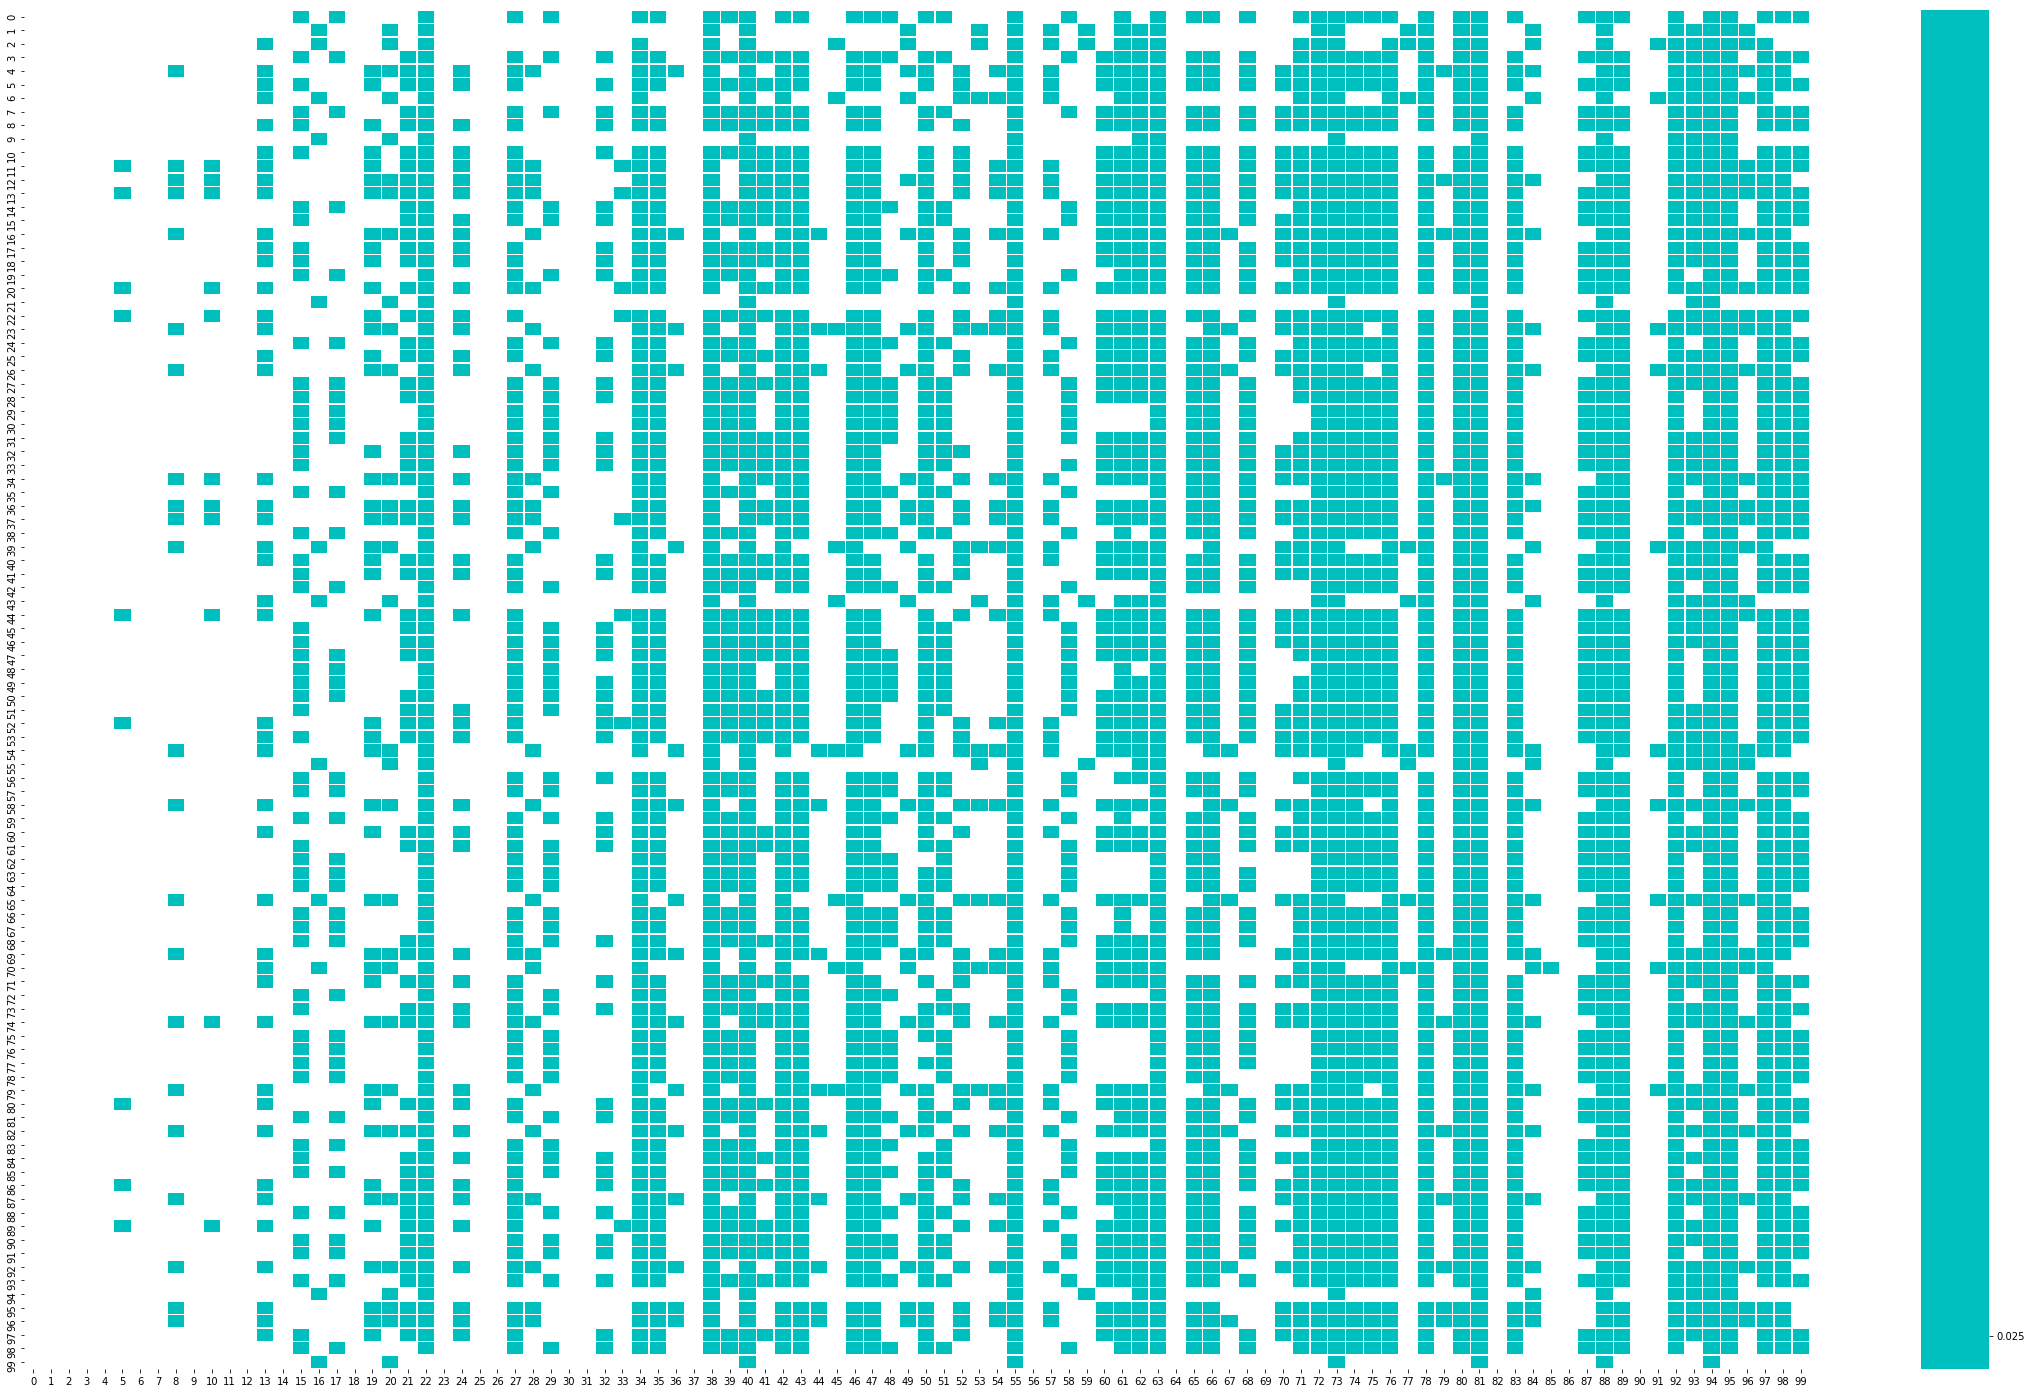

In [104]:
no_ob=spy_stats.ttest_ind(a, c, nan_policy='omit')
# print(no_ov[1])
no_ob_fdr=st.stats.multitest.fdrcorrection(no_ob[1], alpha=0.025, method='indep', is_sorted=False)
# print(np.nanmin(no_ob_fdr[1]))
coor_fig(no_ob_fdr[1])

In [37]:
ps=np.array(fdr[1])

In [38]:
ps.shape

(100, 100)

In [103]:
def coor_fig(df):
    plt.figure(figsize=(40,25))
    m=np.nanmin(df)
    M=np.nanmax(df)
    med=df.mean()
    cmap1 = mlp.colors.ListedColormap(['c'])
    ax = sns.heatmap(df, linewidth=0.5, vmin=m, vmax=M, 
    cmap=cmap1, cbar_kws=dict(ticks=[0.025]), mask=df > 0.025,)
    return(plt.show())

In [18]:
correlation_matrices = correlation_measure.fit_transform(listcorr_dict['NR']['no'])

In [22]:
from nilearn.connectome import sym_matrix_to_vec


X = sym_matrix_to_vec(correlation_matrices)
X.shape

(156, 5050)

# Between modules metrics

# Within module metrics

# Using visbrain to look at the cifti files

In [ ]:
# Scene creation
sc = SceneObj(bgcolor='black', size=(1400, 1000))
# Colorbar default arguments. See `visbrain.objects.ColorbarObj`
CBAR_STATE = dict(cbtxtsz=12, txtsz=10., width=.1, cbtxtsh=3.,
                  rect=(-.3, -2., 1., 4.))
KW = dict(title_size=14., zoom=1.2)


In [ ]:
# Download the annotation file of the left hemisphere lh.aparc.a2009s.annot
path_to_file1 = download_file('lh.aparc.a2009s.annot', astype='example_data')
# Define the brain object (now you should know how to do it)
b_obj_parl = BrainObj('inflated', hemisphere='left', translucent=False)
# Print parcellates included in the file
# print(b_obj_parl.get_parcellates(path_to_file1))
# Finally, parcellize the brain and add the brain to the scene
b_obj_parl.parcellize(path_to_file1)
sc.add_to_subplot(b_obj_parl, row=1, col=1, rotate='left',
                  title='Parcellize using the Desikan Atlas', **KW)


In [ ]:
# Download the lh.sig.nii.gz file
file = download_file('lh.sig.nii.gz', astype='example_data')
# Define the [...] you know
b_obj_fmri = BrainObj('inflated', translucent=False, sulcus=True)
# Add fMRI activation and hide every activation that is under 5.
b_obj_fmri.add_activation(file=file, clim=(5., 20.), hide_under=5,
                          cmap='viridis', hemisphere='left')
sc.add_to_subplot(b_obj_fmri, row=2, col=1, title='Add fMRI activation',
                  rotate='left', **KW)


In [ ]:
# Link the rotation of subplots (row=0, col=1) and (row=1, col=2)
# sc.link((0, 1), (1, 2))
# Screenshot of the scene
# sc.screenshot('ex_brain_obj.png', transparent=True)

sc.preview()